In [3]:
import numpy as np
from sys import path

path.append('src/')
from samplers import WienerRainbowPutOptionSampler, GeometricBrownianMotionPutSampler
from american_monte_carlo import PricerAmericanMonteCarlo
from basis_functions import PolynomialTransformer
import matplotlib.pyplot as plt
from BinomialTree import price_gbm_put

In [2]:
%load_ext autoreload
%autoreload 2

# Rainbow Wiener 2-dimensional

In [3]:
sampler = WienerRainbowPutOptionSampler(
    cnt_trajectories=1_000_000,
    cnt_times=3,
    t=1,
    time_grid = None,
    seed = 345,
    sigmas = [1., 1.],
    strike=0.
)

sampler.sample()

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

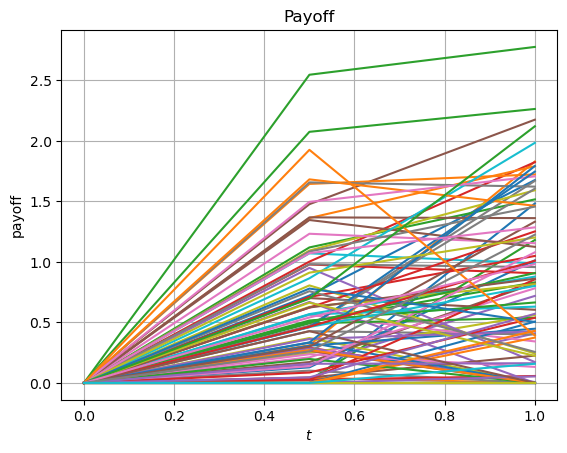

In [4]:
sampler.plot(100)

In [5]:
in_the_money_indices = np.where(sampler.payoff[:, 1] > 1e-9)[0]
len(in_the_money_indices)

749942

In [6]:
features = sampler.markov_state[in_the_money_indices, 1]
transformed = PolynomialTransformer(5).fit_transform(features)
transformed.shape

(749942, 21)

In [7]:
regularization = np.eye(transformed.shape[1], dtype=float) * 0.
inv = np.linalg.pinv((transformed.T @ transformed + regularization), rcond=1e-4)
weights = inv @ transformed.T @ sampler.payoff[in_the_money_indices, 2]
continuation_value = transformed @ weights

In [8]:
indicator = (continuation_value < sampler.payoff[in_the_money_indices, 1])
indicator.sum()

1109

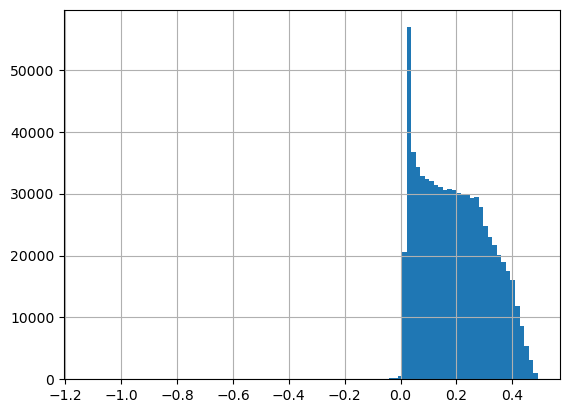

In [9]:
plt.hist(continuation_value - sampler.payoff[in_the_money_indices, 1], bins=100);
plt.grid()

# Тесты AMC (Одномерный) vs Tree

In [4]:
import numpy as np
from sys import path

path.append('src/')
from samplers import WienerRainbowPutOptionSampler, GeometricBrownianMotionPutSampler
from american_monte_carlo import PricerAmericanMonteCarlo
from basis_functions import PolynomialTransformer
import matplotlib.pyplot as plt
from BinomialTree import price_gbm_put


In [11]:
from american_monte_carlo import _plot_progress

In [12]:
option_params = {
    "asset0": 100.,
    "sigma": 0.1,
    "r": 0.5,
    "strike": 100.,
    "t": 1
}

In [13]:
EPSILON = 1e-1
CNT_TIMES = 100

#### Варьируем `r (mu)`

`--` будет нижней оценкой, `-.` верхней

In [14]:
r_linspace = np.linspace(0, 1, num = 15)

 88%|########7 | 87/99 [00:00<00:00, 119.59it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


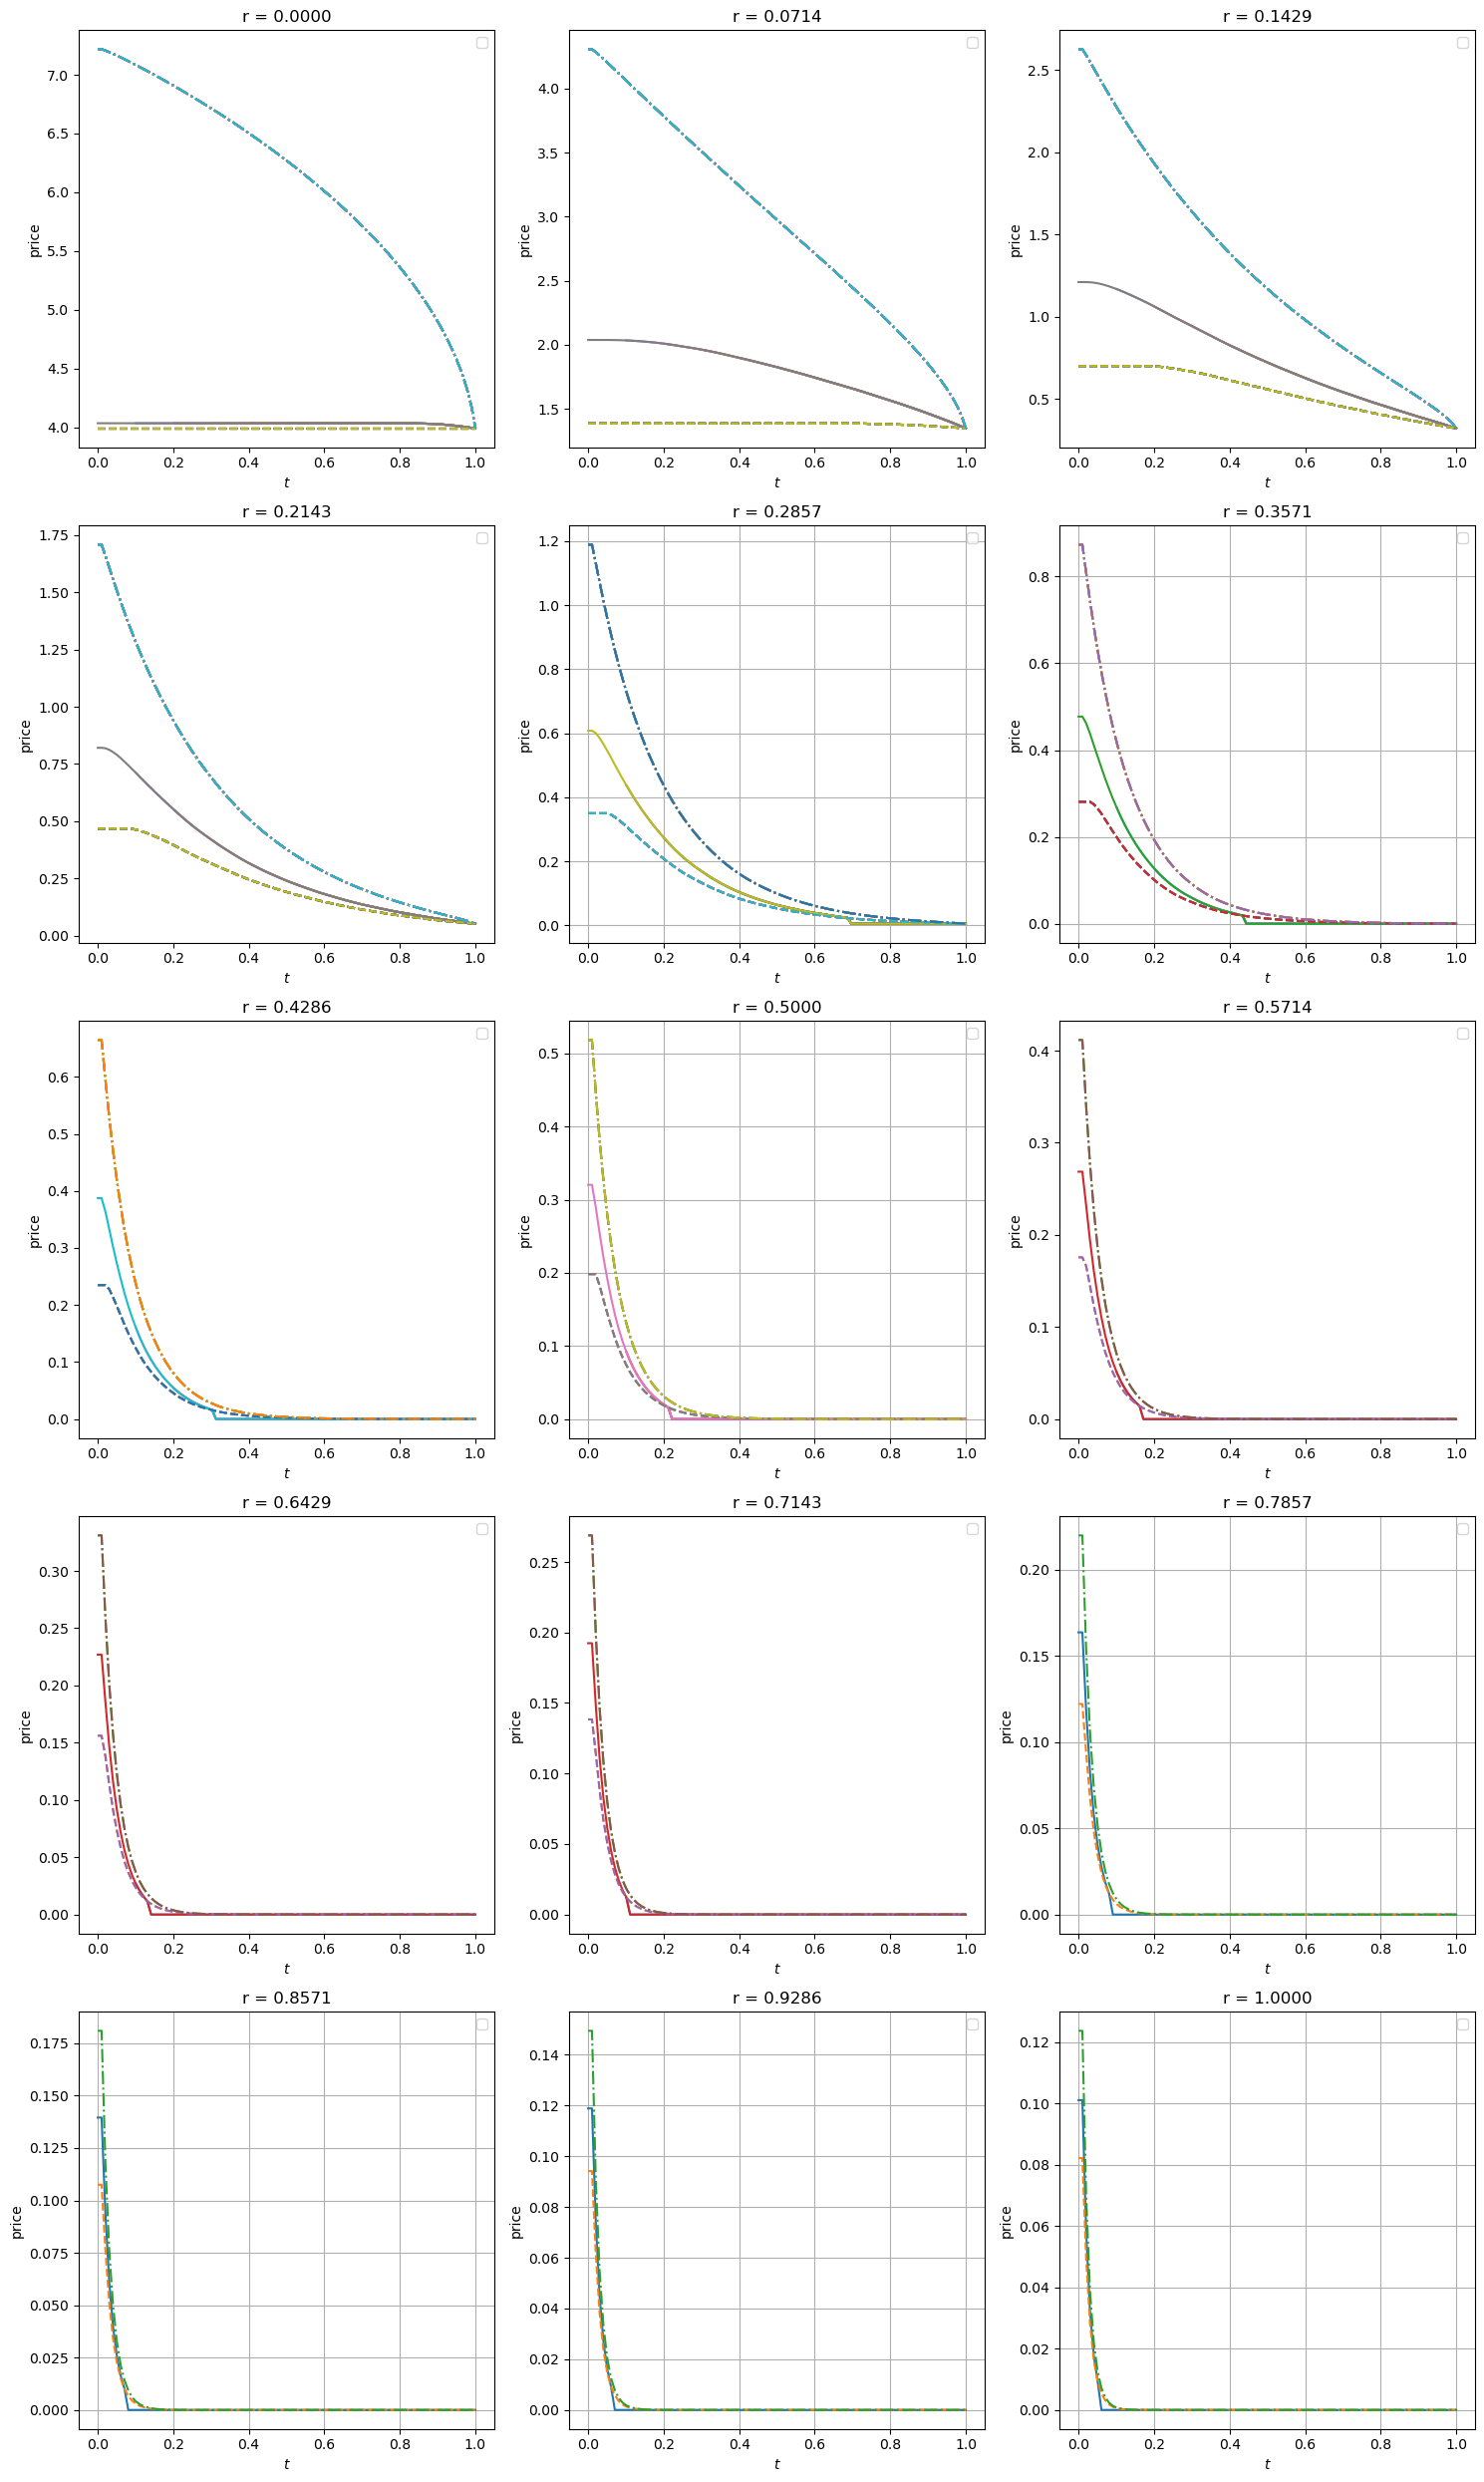

In [7]:
nums = len(r_linspace)

nrows = 5
ncols = 3  
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 25))
axes = axes.flatten()

for idx, r_val in enumerate(r_linspace):
    option_params["r"] = r_val
    
    amc = PricerAmericanMonteCarlo(
        sampler=GeometricBrownianMotionPutSampler(
            cnt_trajectories=1_000_000,
            cnt_times=100,
            seed=345,
            **option_params
        ),
        regularization_alpha=1e-3
    )

    ax = axes[idx]
    amc.price(test=False, quiet=False, ax=ax)
    ax.set_title(f"r = {r_val:.4f}")

plt.tight_layout()
plt.show()

при варьировании `r` дереву нужно больше шагов, чтобы нормально приблизить цену. иногда дерево просто её зануляет, как например сейчас при `cnt_times = 100`, но если увеличить `cnt_times` , то уже всё будет ок

In [15]:
def run_value_grid(param_name, param_grid, times_counter, nrows=5, ncols=2, figsize=(15, 25)):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()

    for idx, param_val in enumerate(param_grid):
       
        option_params_copy = option_params.copy()
        option_params_copy[param_name] = param_val
        
        amc = PricerAmericanMonteCarlo(
            sampler=GeometricBrownianMotionPutSampler(
                cnt_trajectories=1_000_000,
                cnt_times=times_counter,
                seed=345,
                **option_params_copy
            ),
            regularization_alpha=1e-3
        )
        
        ax = axes[idx]
        amc.price(test=False, quiet=False, ax=ax)
        ax.set_title(f"{param_name} = {param_val:.4f}")

    plt.tight_layout()
    plt.show()

### Sigma

In [15]:
sigma_grid = np.linspace(0.1, 2, num = 10)

 99%|#########8| 98/99 [00:06<00:00, 17.27it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


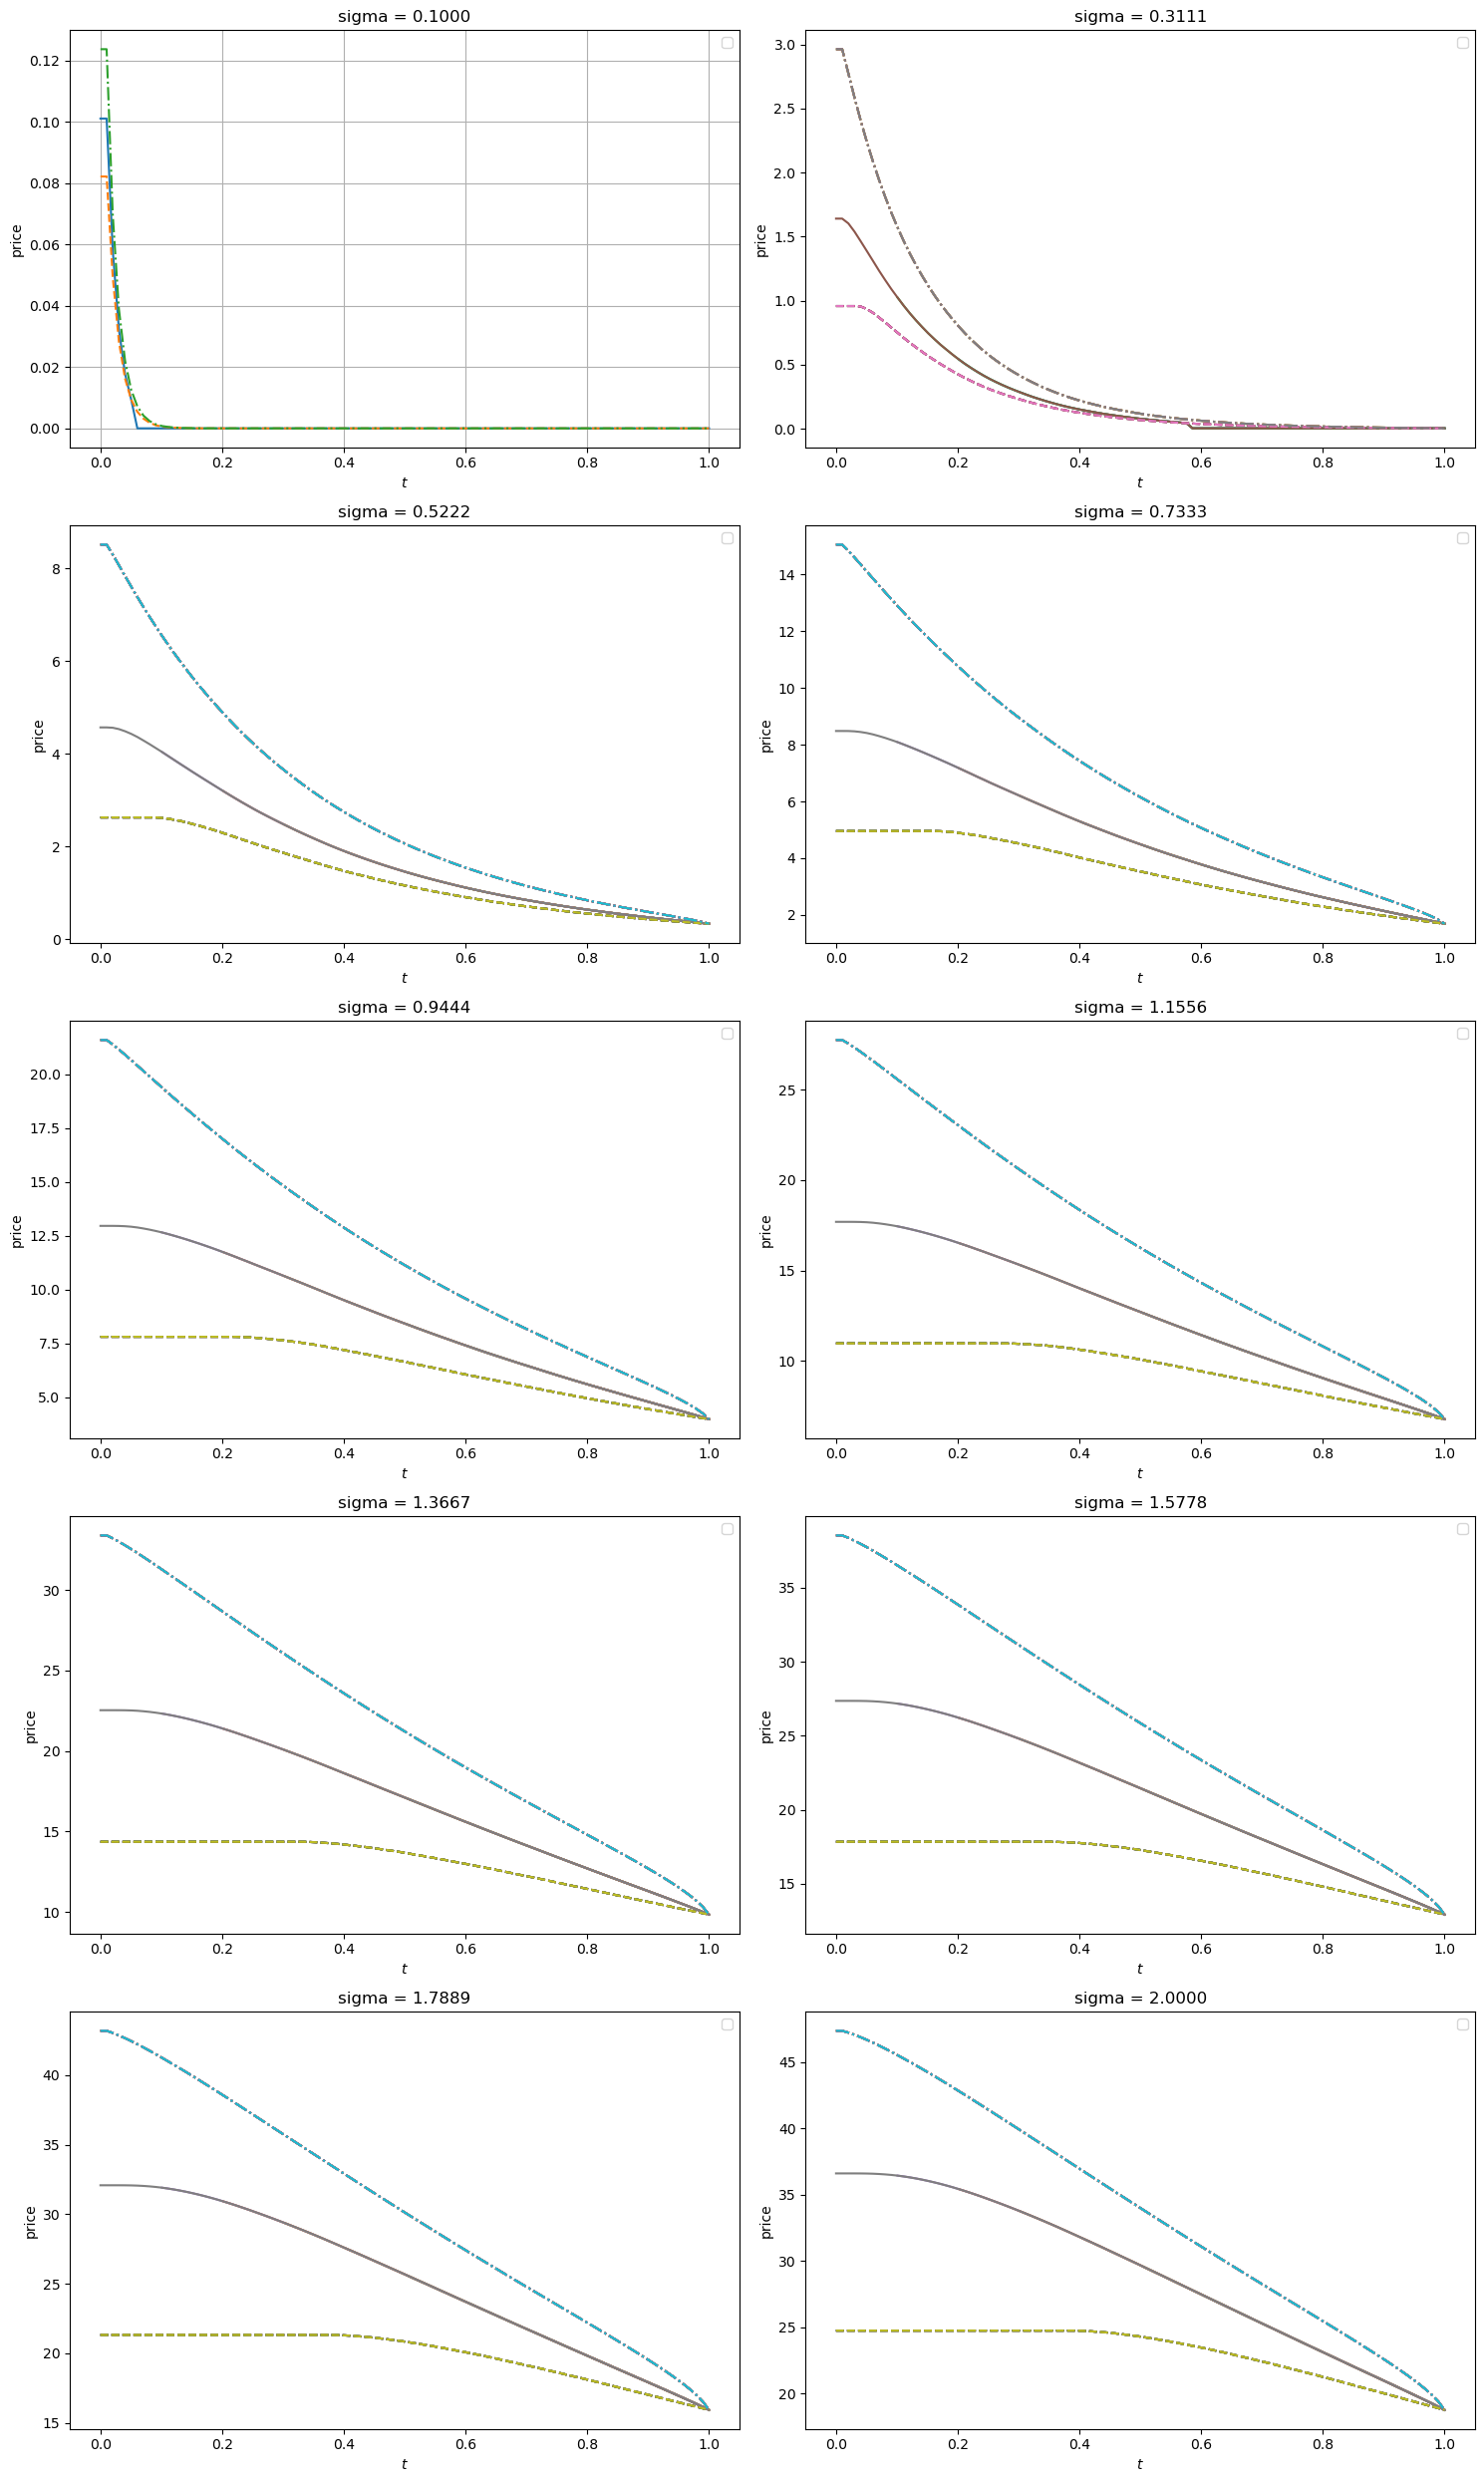

In [17]:
run_value_grid("sigma", sigma_grid, times_counter = CNT_TIMES)

если увеличить `cnt_times`, то при бОльших значениях волатильности предикты дерева и AMC будут ближе

### Время до истечения опциона `t`

In [22]:
time_grid = np.linspace(0.01, 1, num = 10)

 96%|#########5| 95/99 [00:00<00:00, 113.84it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


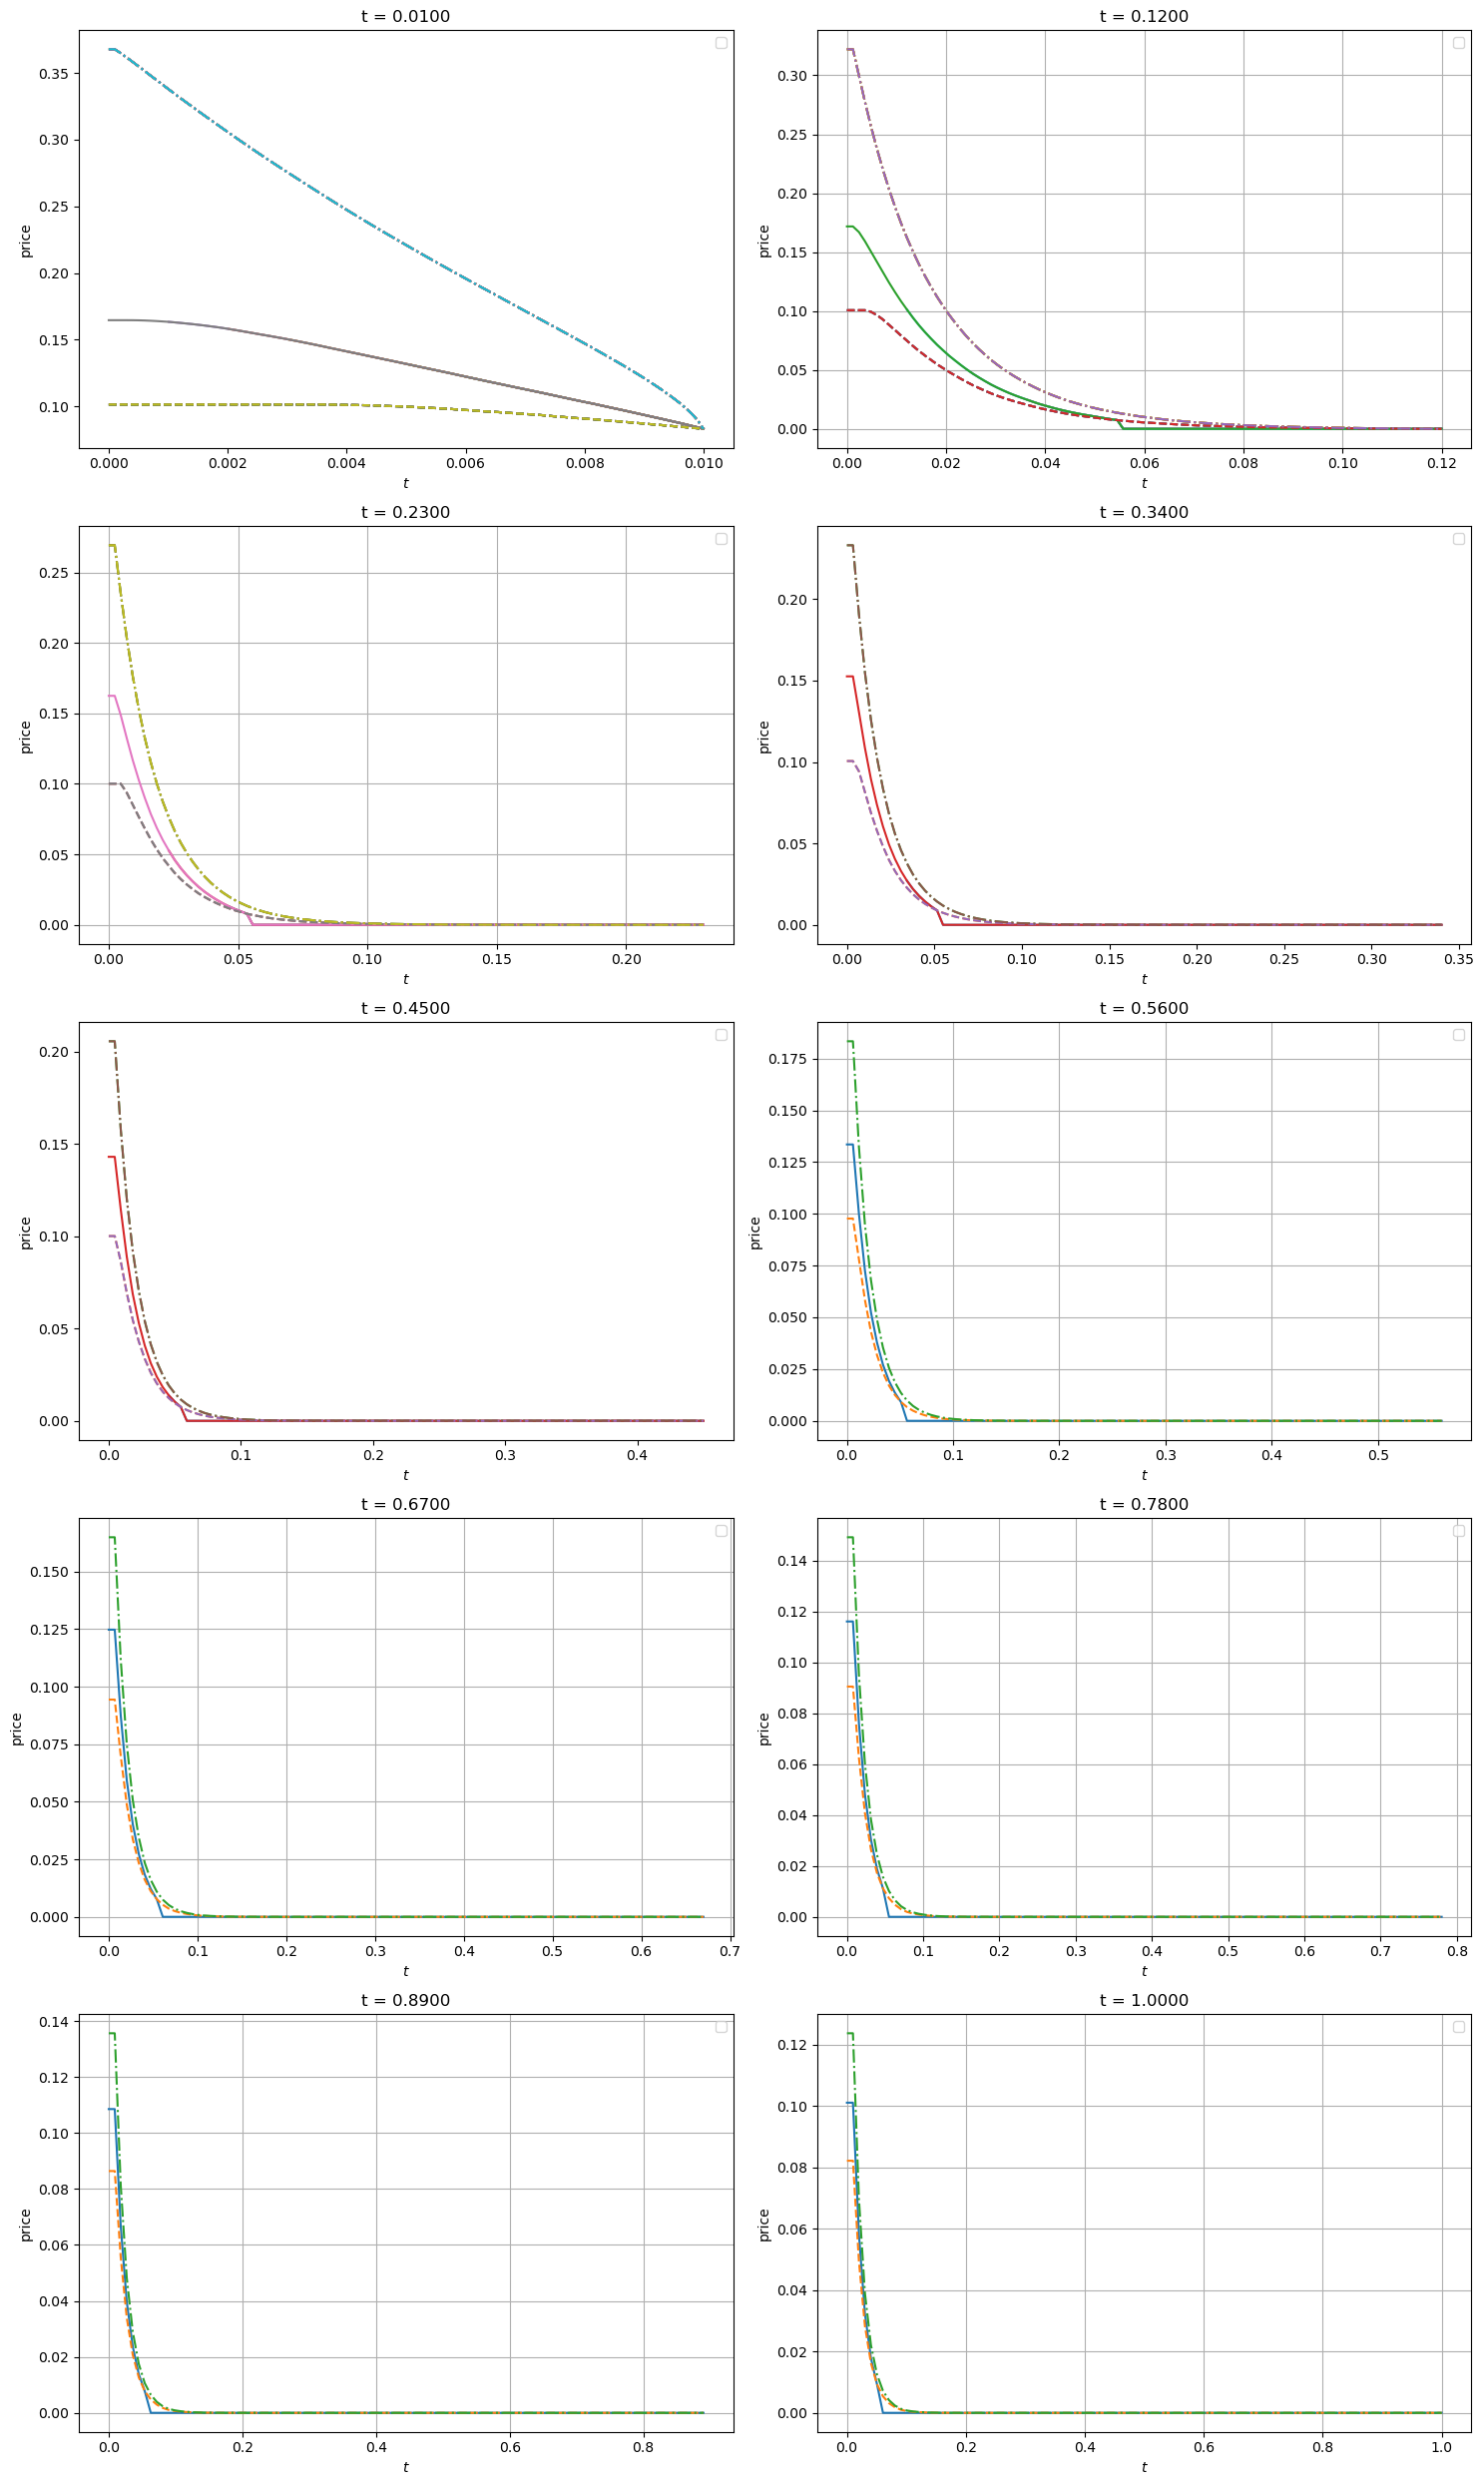

In [23]:
run_value_grid("t", time_grid, times_counter = 100)

тоже в целом всё ок, если увеличить `cnt_times` то будем ближе

# Сравнение с деревом

In [16]:
def tree_comparator(param_name, param_grid, times_counter=CNT_TIMES):
    for param_val in param_grid:
        option_params_copy = option_params.copy()
        option_params_copy[param_name] = param_val
        
        # AMC
        amc = PricerAmericanMonteCarlo(
            sampler=GeometricBrownianMotionPutSampler(
                cnt_trajectories=1_000_000,
                cnt_times=times_counter,
                seed=345,
                **option_params_copy
            ),
            regularization_alpha=1e-3
        )
        amc.price(test=False, quiet=True)
        
        # Биномиальное дерево с обновленными параметрами
        _, tree_price = price_gbm_put(**option_params_copy, cnt_times=times_counter)
        
        print(f"значение параметра {param_name} = {param_val}")
        print(f"предикт AMC {amc.price_history[0]} vs предикт дерева {tree_price[0]}")
        print()

# Варьируем `r (mu)`

In [10]:
r_linspace = np.linspace(0, 1, num = 15)

In [11]:
tree_comparator("r", r_linspace)

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра r = 0.0
предикт AMC 3.980723165053406 vs предикт дерева 3.9927865695358298



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра r = 0.07142857142857142
предикт AMC 2.024931305537694 vs предикт дерева 2.027797129321674



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра r = 0.14285714285714285
предикт AMC 1.2149928737369504 vs предикт дерева 1.2109782630937005



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра r = 0.21428571428571427
предикт AMC 0.8260252170300293 vs предикт дерева 0.8162662714028909



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра r = 0.2857142857142857
предикт AMC 0.6114664546746698 vs предикт дерева 0.5991276487749533



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра r = 0.3571428571428571
предикт AMC 0.4791324172212705 vs предикт дерева 0.46610717438617477



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра r = 0.42857142857142855
предикт AMC 0.38820165100464815 vs предикт дерева 0.36857413040622367



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра r = 0.5
предикт AMC 0.3210291116167195 vs предикт дерева 0.29337317724566897



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра r = 0.5714285714285714
предикт AMC 0.26879948044104296 vs предикт дерева 0.23488676450803508



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра r = 0.6428571428571428
предикт AMC 0.22695572033086184 vs предикт дерева 0.18606939286989452



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра r = 0.7142857142857142
предикт AMC 0.19246065290853248 vs предикт дерева 0.14421344302931385



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра r = 0.7857142857142857
предикт AMC 0.16356530346318918 vs предикт дерева 0.10741531178534255



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра r = 0.8571428571428571
предикт AMC 0.13944878487987022 vs предикт дерева 0.07147435650532494



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра r = 0.9285714285714285
предикт AMC 0.11878733401140927 vs предикт дерева 0.03571907831874379



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра r = 1.0
предикт AMC 0.10101581087409595 vs предикт дерева 0.0



видим, что при `cnt_times = 100` дереву в конце становится плохо. возьмём `cnt_times = 300` и сравним выходы AMC и дерева при последних значениях `r`. Дерево должно сблизиться с AMC

In [13]:
last_r_vals = (0.8571428571428571, 0.9285714285714285, 1.0)
LAST_CNT_TIMES = 300

In [14]:
tree_comparator("r", last_r_vals, LAST_CNT_TIMES)

  0%|          | 0/299 [00:00<?, ?it/s]

  0%|          | 0/299 [00:00<?, ?it/s]

значение параметра r = 0.8571428571428571
предикт AMC 0.1893585112359196 vs предикт дерева 0.17262052606407421



  0%|          | 0/299 [00:00<?, ?it/s]

  0%|          | 0/299 [00:00<?, ?it/s]

значение параметра r = 0.9285714285714285
предикт AMC 0.170544216422445 vs предикт дерева 0.1522677277308465



  0%|          | 0/299 [00:00<?, ?it/s]

  0%|          | 0/299 [00:00<?, ?it/s]

значение параметра r = 1.0
предикт AMC 0.1543026551745543 vs предикт дерева 0.13355642198113213



# Варьируем `sigma`

In [16]:
sigma_grid = np.linspace(0.1, 2, num = 10)

In [17]:
tree_comparator("sigma", sigma_grid, 100)

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра sigma = 0.1
предикт AMC 0.3210291116167195 vs предикт дерева 0.29337317724566897



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра sigma = 0.3111111111111111
предикт AMC 3.3043105942545608 vs предикт дерева 3.2885654495701395



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра sigma = 0.5222222222222223
предикт AMC 8.22398104416681 vs предикт дерева 8.232584022410279



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра sigma = 0.7333333333333333
предикт AMC 13.939609816164824 vs предикт дерева 13.956015207468536



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра sigma = 0.9444444444444444
предикт AMC 19.916769266507334 vs предикт дерева 19.97072966160143



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра sigma = 1.1555555555555557
предикт AMC 25.878933267822497 vs предикт дерева 25.93508332597537



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра sigma = 1.3666666666666667
предикт AMC 31.698218031245112 vs предикт дерева 31.72825140439927



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра sigma = 1.577777777777778
предикт AMC 37.29460743935396 vs предикт дерева 37.29690483538323



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра sigma = 1.788888888888889
предикт AMC 42.601922078502284 vs предикт дерева 42.608939972321984



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра sigma = 2.0
предикт AMC 47.54884644059961 vs предикт дерева 47.51805277677689



# Варьируем `t`

In [18]:
time_grid = np.linspace(0.01, 1, num = 10)

In [19]:
tree_comparator("t", time_grid, 100)

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра t = 0.01
предикт AMC 0.24561178540850978 vs предикт дерева 0.2456766664113904



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра t = 0.12
предикт AMC 0.3557258654834956 vs предикт дерева 0.35266948857362745



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра t = 0.23
предикт AMC 0.355101568846795 vs предикт дерева 0.3487929954679672



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра t = 0.34
предикт AMC 0.35014906636261517 vs предикт дерева 0.34282606387015546



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра t = 0.45
предикт AMC 0.3455279895916441 vs предикт дерева 0.33776264452504107



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра t = 0.56
предикт AMC 0.34087669944422566 vs предикт дерева 0.3296732662915146



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра t = 0.67
предикт AMC 0.33594099151174106 vs предикт дерева 0.32125819008656387



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра t = 0.78
предикт AMC 0.33117014246191073 vs предикт дерева 0.3121302799644024



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра t = 0.89
предикт AMC 0.32615900694906297 vs предикт дерева 0.30222483354546303



  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

значение параметра t = 1.0
предикт AMC 0.3210291116167195 vs предикт дерева 0.29337317724566897



# Многомерный AMC

In [3]:
amc = PricerAmericanMonteCarlo(
    sampler=WienerRainbowPutOptionSampler(
        cnt_trajectories=1_000_000,
        cnt_times=30,
        t = 1,
        time_grid = None,
        seed = 345,
        sigmas = [1, 2],
        strike = 50
    ),
    regularization_alpha=1e-4
)

 97%|#########6| 28/29 [00:08<00:00,  3.56it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


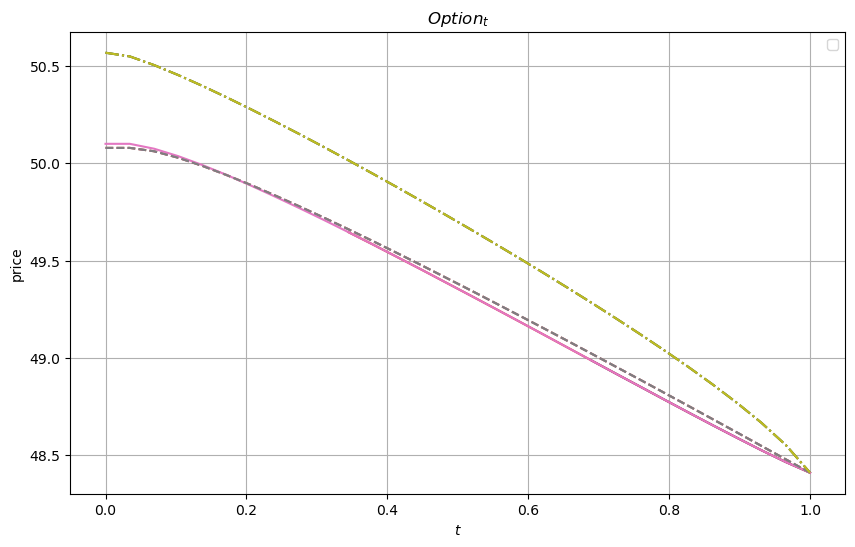

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))
amc.price(test=False, quiet=False, ax=ax)
plt.show()

######## strike = 50

In [12]:
amc = PricerAmericanMonteCarlo(
    sampler=WienerRainbowPutOptionSampler(
        cnt_trajectories=1_000_000,
        cnt_times=30,
        t = 1,
        time_grid = None,
        seed = 345,
        sigmas = [1, 1],
        strike = 25
    ),
    regularization_alpha=1e-4
)

 97%|#########6| 28/29 [00:04<00:00,  5.71it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


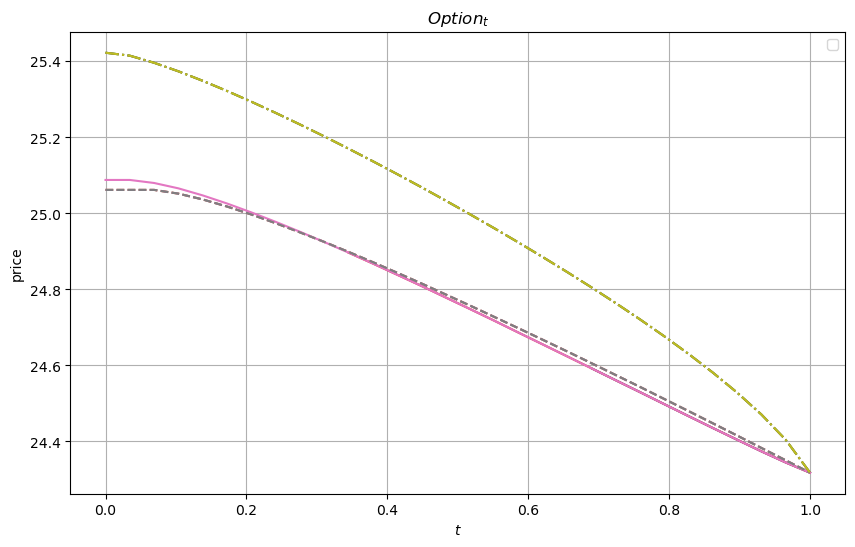

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
amc.price(test=False, quiet=False, ax=ax)
plt.show()

##### strike = 25

In [14]:
amc = PricerAmericanMonteCarlo(
    sampler=WienerRainbowPutOptionSampler(
        cnt_trajectories=1_000_000,
        cnt_times=30,
        t = 1,
        time_grid = None,
        seed = 345,
        sigmas = [1, 1],
        strike = 10
    ),
    regularization_alpha=1e-4
)

 97%|#########6| 28/29 [00:05<00:00,  5.69it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


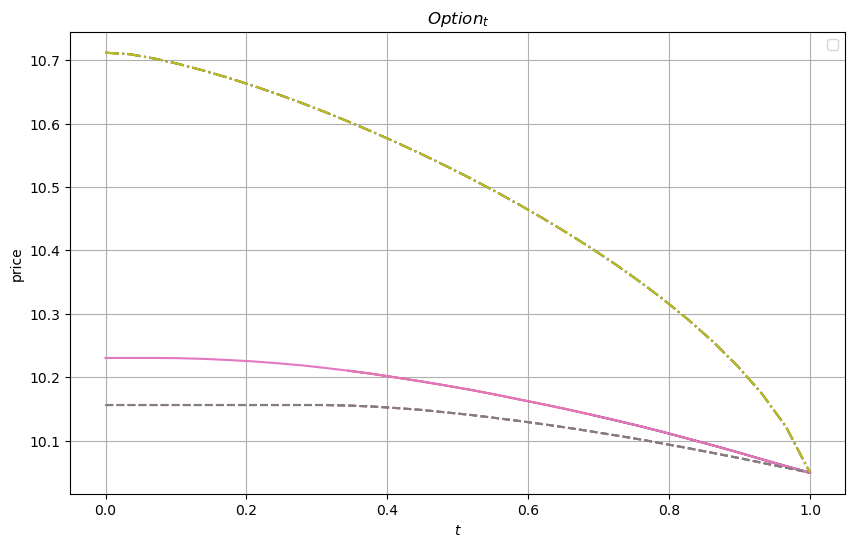

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
amc.price(test=False, quiet=False, ax=ax)
plt.show()


####### strike = 10

In [16]:
amc = PricerAmericanMonteCarlo(
    sampler=WienerRainbowPutOptionSampler(
        cnt_trajectories=1_000_000,
        cnt_times=30,
        t = 1,
        time_grid = None,
        seed = 345,
        sigmas = [1, 1],
        strike = 0.
    ),
    regularization_alpha=1e-4
)

 97%|#########6| 28/29 [00:03<00:00,  7.12it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


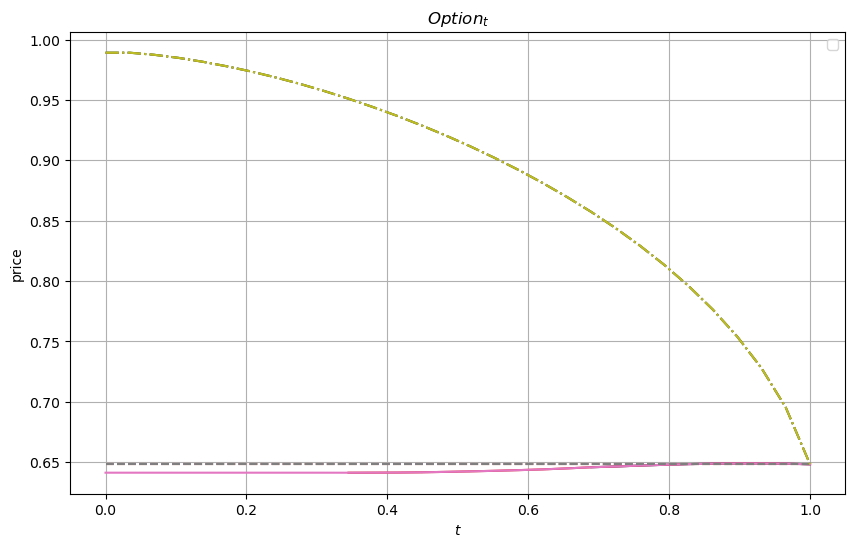

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
amc.price(test=False, quiet=False, ax=ax)
plt.show()


####### strike = 0

## Посмотрим на поведение многомерного AMC в з-ти от размерности базиса при `strike = 0`

Фиксируем `cnt_traj = 1_000_000`

In [2]:
option_basis_test_params = {
    "sigmas": [0.2, 0.3], 
    "strike": 0.,        
    "r": 0.05,            
    "t": 1.0,              
    "cnt_trajectories": 1_000_000,  
    "cnt_times": 50,     
    "seed": 345           
}

In [18]:
def analyze_basis_impact(degrees, option_basis_test_params, regularization_alpha=1e-4):
    fig, axes = plt.subplots(len(degrees), 1, figsize=(10, 6 * len(degrees)))
    if len(degrees) == 1:
        axes = [axes]  

    for idx, degree in enumerate(degrees):
        sampler = WienerRainbowPutOptionSampler(**option_basis_test_params)
        amc = PricerAmericanMonteCarlo(
            sampler=sampler,
            degree=degree,
            regularization_alpha=regularization_alpha
        )

        ax = axes[idx]
        amc.price(test=True, quiet=False, ax=ax)
        ax.set_title(f"Degree = {degree}")
        ax.legend(["AMC Price", "Lower Bound", "Upper Bound"])

    plt.tight_layout()
    plt.show()

 98%|#########7| 48/49 [00:35<00:00,  1.32it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


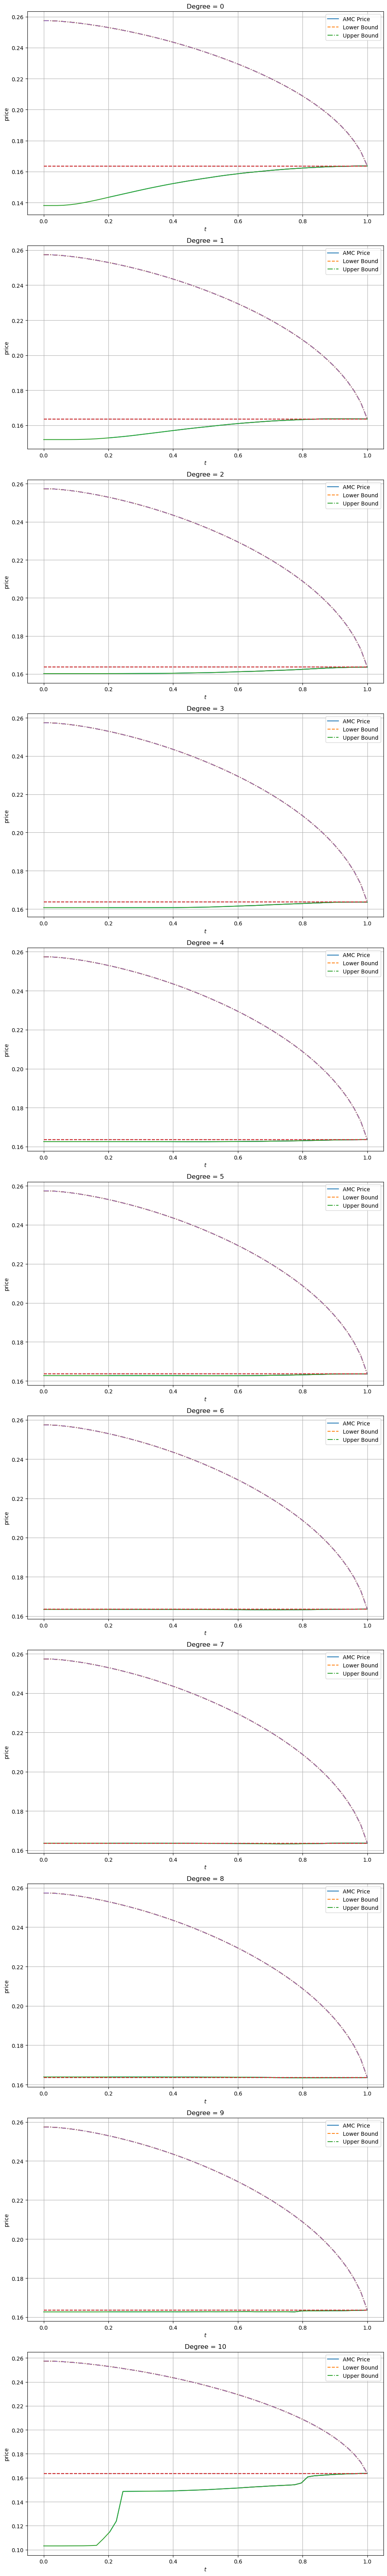

In [7]:
degrees = tuple(i for i in range(11))
analyze_basis_impact(degrees, option_basis_test_params)


##################### Не надо смотреть на легенду. Зелёное - это AMC, штриховая линия - нижняя оценка. Штрих - пунктир - верхняя оценка #############################

# Возьмем другой `strike = 10`

In [22]:
option_basis_test_params["strike"] = 10

 98%|#########7| 48/49 [00:31<00:00,  1.58it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


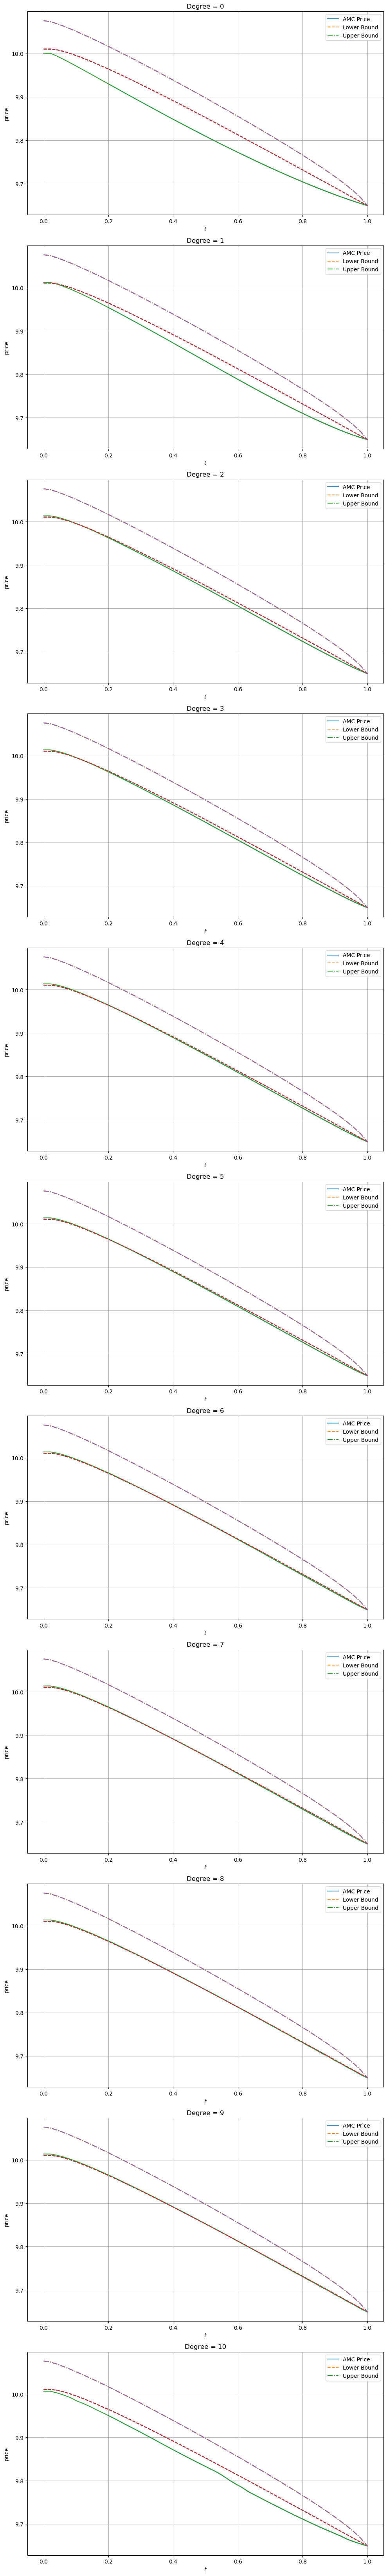

In [23]:
analyze_basis_impact(degrees, option_basis_test_params)

# `strike = 15`

In [19]:
option_basis_test_params["strike"] = 15

 98%|#########7| 48/49 [00:28<00:00,  1.67it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


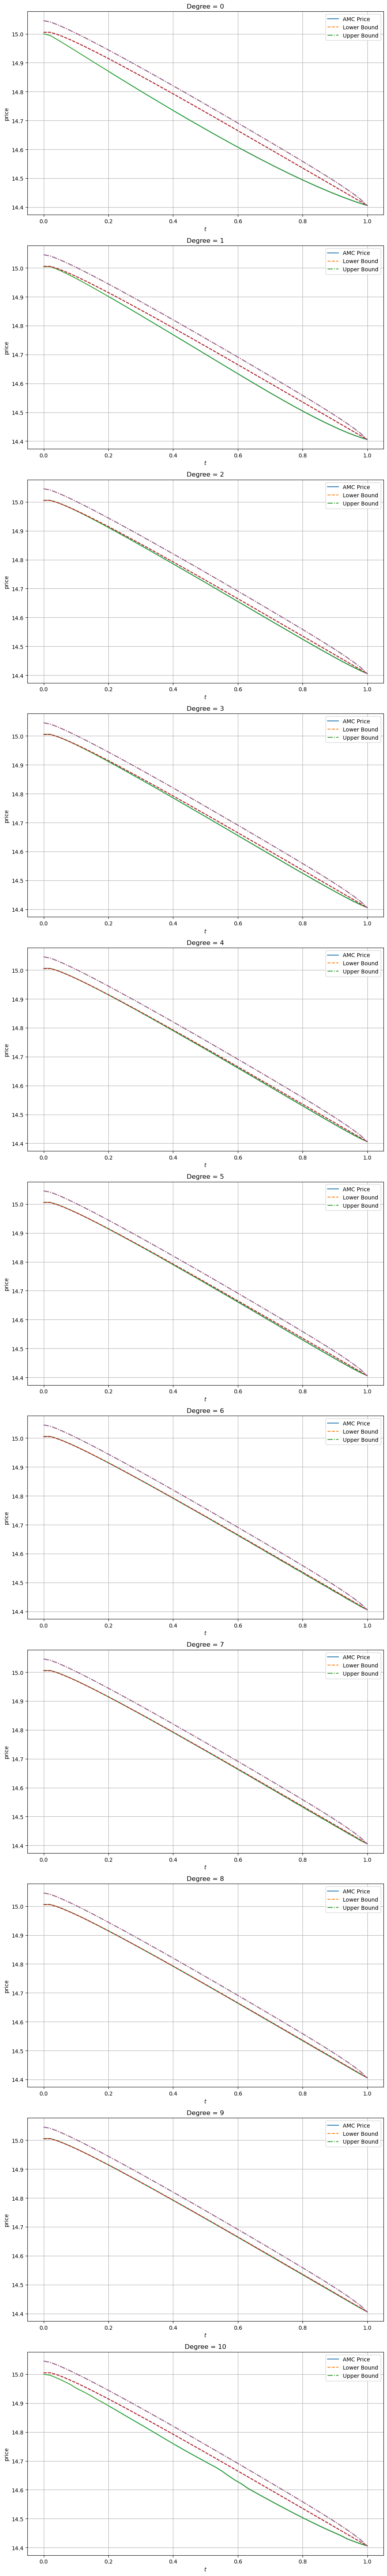

In [27]:
analyze_basis_impact(degrees, option_basis_test_params)

Дальше при увеличении `stike` оно уже всё будет в одну сплошную неразличимую линию, поэтому я брал небольшие значения. 

# Тест с LSPI

In [2]:
from datetime import date
from options import AmericanOption, OptionType, Stock
from samplers import GeometricBrownianMotionPutSampler
from LSPI_rl import LSPIPricer
from tqdm import tqdm

ModuleNotFoundError: No module named 'options'

In [7]:
option_params = {
    "asset0": 100.,
    "sigma": 0.2,
    "r": 0.05,
    "strike": 100.,
    "t": 1,
    "cnt_times": 1000
}

In [1]:
sampler = GeometricBrownianMotionPutSampler(
    cnt_trajectories = 1000,          
    seed = 42,                 
    **option_params
)
sampler.sample()  # generate the sample price paths

NameError: name 'GeometricBrownianMotionPutSampler' is not defined

In [20]:
amc = PricerAmericanMonteCarlo(
        sampler = sampler,
        regularization_alpha = 1e-3
    )

 98%|#########8| 982/999 [00:04<00:00, 241.73it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


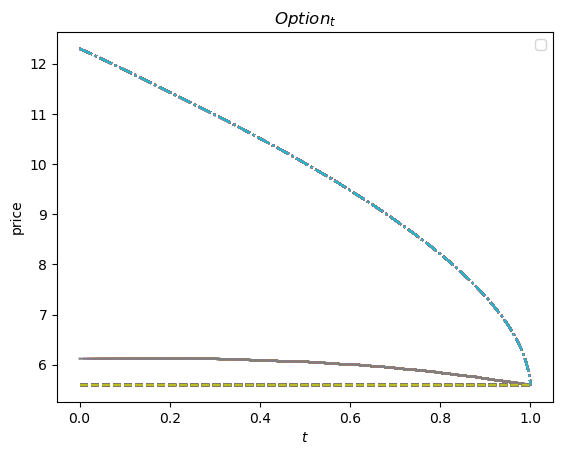

In [21]:
amc_results = amc.price(test = False, quiet = False)

In [22]:
amc_results[0]

6.12145066843621

In [23]:
_, tree_price = price_gbm_put(**option_params)

In [24]:
tree_price[0]

6.090612801532148

In [ ]:
pricer = LSPIPricer(iterations = 10, tol = 1e-6, lambda_reg = 1e-6, epsilon = 1e-6)
pv_payoffs = pricer.price(sampler, **option_params)

In [17]:
option_price = np.mean(pv_payoffs)

In [18]:
option_price

5.513354148500922

# Простое тестирование

In [4]:
import numpy as np
import pandas as pd
import time
from itertools import product
from tqdm import tqdm  # Добавляем tqdm для прогресс-бара
from samplers import GeometricBrownianMotionPutSampler

test_params = {
    "asset0": [80, 120, 140],          
    "sigma": [0.1, 0.3, 0.5],         
    "strike": [90, 110, 130],                   
    "t": [0.5, 1.0, 2.0],            
    "r": [0.03, 0.05],           
    "cnt_times": [365],              
    "cnt_trajectories": [1000, 2000, 3000]  
}

In [36]:
def run_test(option_params, cnt_trajectories, cnt_times, seed=42):
    # Создаём копию option_params
    option_params = option_params.copy()
    # Устанавливаем cnt_times и strike
    option_params["cnt_times"] = cnt_times
    option_params["strike"] = test_params["strike"][0]  # Добавляем strike

    # Инициализация sampler
    sampler = GeometricBrownianMotionPutSampler(
        cnt_trajectories=cnt_trajectories,
        seed=seed,
        **option_params
    )
    
    # Время генерации траекторий
    start_time = time.time()
    sampler.sample()
    sample_time = time.time() - start_time

    # AMC
    start_time = time.time()
    amc = PricerAmericanMonteCarlo(
        sampler=sampler,
        regularization_alpha=1e-3
    )
    amc_results = amc.price(test=False, quiet=True)
    amc_price = amc_results[0]
    amc_time = time.time() - start_time

    # BinaryTree
    start_time = time.time()
    _, tree_price = price_gbm_put(**option_params)
    tree_price = tree_price[0]
    tree_time = time.time() - start_time

    # LSPI
    start_time = time.time()
    pricer = LSPIPricer(iterations = 10, tol=1e-6, lambda_reg=1e-6, epsilon=1e-6)
    pv_payoffs = pricer.price(sampler, **option_params)
    lspi_price = np.mean(pv_payoffs)
    lspi_time = time.time() - start_time

    # Результаты
    return {
        "asset0": option_params["asset0"],
        "sigma": option_params["sigma"],
        "strike": option_params["strike"],
        "t": option_params["t"],
        "r": option_params["r"],
        "cnt_trajectories": cnt_trajectories,
        "cnt_times": cnt_times,
        "BinaryTree_price": tree_price,
        "AMC_price": amc_price,
        "LSPI_price": lspi_price,
        "BinaryTree_time": tree_time,
        "AMC_time": amc_time,
        "LSPI_time": lspi_time,
        "LSPI_minus_BinaryTree": (tree_price - lspi_price),
        "LSPI_minus_AMC": (amc_price - lspi_price),
        "AMC_minus_BinaryTree": (tree_price - amc_price)
    }

In [41]:
results = []

# Генерация всех комбинаций параметров
keys = ["asset0", "sigma", "t", "r"]
values = [test_params[key] for key in keys]
combinations = list(product(*values))

# Вычисляем общее количество итераций для tqdm
total_iterations = len(combinations) * len(test_params["cnt_trajectories"]) * len(test_params["cnt_times"])

# Запуск тестов с прогресс-баром
with tqdm(total=total_iterations, desc="Running tests") as pbar:
    for combo in combinations:
        option_params = dict(zip(keys, combo))
        for cnt_trajectories in test_params["cnt_trajectories"]:
            for cnt_times in test_params["cnt_times"]:
                result = run_test(option_params, cnt_trajectories, cnt_times)
                results.append(result)
                pbar.update(1)  # Обновляем прогресс-бар после каждого теста

# Создание DataFrame
results_df = pd.DataFrame(results)

Running tests:   0%|          | 0/162 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Running tests:   1%|          | 1/162 [00:01<04:26,  1.65s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Running tests:   1%|          | 2/162 [00:04<06:36,  2.48s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Running tests:   2%|▏         | 3/162 [00:09<08:49,  3.33s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Running tests:   2%|▏         | 3/162 [00:09<08:04,  3.04s/it]


KeyboardInterrupt: 

In [38]:
results_df

asset0  sigma  strike    t     r  cnt_trajectories  cnt_times  \
0        80    0.1      90  0.5  0.03              1000       1000   
1        80    0.1      90  0.5  0.03              2000       1000   
2        80    0.1      90  0.5  0.03              3000       1000   
3        80    0.1      90  0.5  0.05              1000       1000   
4        80    0.1      90  0.5  0.05              2000       1000   
..      ...    ...     ...  ...   ...               ...        ...   
157     140    0.5      90  2.0  0.03              2000       1000   
158     140    0.5      90  2.0  0.03              3000       1000   
159     140    0.5      90  2.0  0.05              1000       1000   
160     140    0.5      90  2.0  0.05              2000       1000   
161     140    0.5      90  2.0  0.05              3000       1000   

     BinaryTree_price  AMC_price  LSPI_price  BinaryTree_time  AMC_time  \
0           10.000000  10.070291    9.711831         0.735632  0.846478   
1           10.000000  10.072881   10.000000         0.751251  1.220038   
2           10.000000  10.012298   10.000000         0.741663  1.656443   
3           10.000000  10.021212   10.000000         0.749178  0.764795   
4           10.000000  10.032573   10.000000         0.767991  1.219397   
..                ...        ...         ...              ...       ...   
157         10.667185  10.543617   10.075907         1.471150  2.116708   
158         10.667185  10.557002   10.255596         1.435275  3.069773   
159          9.663944  10.249879    9.366781         1.443687  1.183402   
160          9.663944   9.692686    8.906939         1.433707  2.231191   
161          9.663944   9.531609    9.107956         1.422009  2.913148   

     LSPI_time  LSPI_minus_BinaryTree  LSPI_minus_AMC  AMC_minus_BinaryTree  
0     1.406567               0.288169        0.358460             -0.070291  
1     2.466014               0.000000        0.072881             -0.072881  
2     3.568340               0.000000        0.012298             -0.012298  
3     1.199051               0.000000        0.021212             -0.021212  
4     2.432821               0.000000        0.032573             -0.032573  
..         ...                    ...             ...                   ...  
157   7.596669               0.591278        0.467710              0.123568  
158  11.170319               0.411590        0.301407              0.110183  
159   3.623218               0.297163        0.883098             -0.585936  
160   7.459192               0.757004        0.785747             -0.028743  
161  10.797657               0.555987        0.423653              0.132334  

[162 rows x 16 columns]

In [39]:
import pandas as pd

results_df.to_csv('results.csv', index=False)

In [26]:
print("\nСтатистика по отклонениям:")
print("LSPI vs BinaryTree:")
results_df["LSPI_minus_BinaryTree"].describe()


Статистика по отклонениям:
LSPI vs BinaryTree:


count    48.000000
mean      0.420270
std       0.659111
min      -0.007768
25%       0.000000
50%       0.130615
75%       0.593266
max       2.756375
Name: LSPI_minus_BinaryTree, dtype: float64

In [27]:
results_df[results_df.LSPI_minus_BinaryTree.values < 0].any()

asset0                   True
sigma                    True
strike                   True
t                        True
r                        True
cnt_trajectories         True
cnt_times                True
BinaryTree_price         True
AMC_price                True
LSPI_price               True
BinaryTree_time          True
AMC_time                 True
LSPI_time                True
LSPI_minus_BinaryTree    True
LSPI_minus_AMC           True
AMC_minus_BinaryTree     True
dtype: bool

In [28]:
print("\nLSPI vs AMC:")
results_df["LSPI_minus_AMC"].describe()


LSPI vs AMC:


count    48.000000
mean      0.512921
std       0.713277
min      -0.001101
25%       0.029987
50%       0.197325
75%       0.770981
max       3.163968
Name: LSPI_minus_AMC, dtype: float64

In [48]:
results_df[results_df.LSPI_minus_AMC.values < 0].any()

asset0                   False
sigma                    False
strike                   False
t                        False
r                        False
cnt_trajectories         False
cnt_times                False
BinaryTree_price         False
AMC_price                False
LSPI_price               False
BinaryTree_time          False
AMC_time                 False
LSPI_time                False
LSPI_minus_BinaryTree    False
LSPI_minus_AMC           False
AMC_minus_BinaryTree     False
dtype: bool

# график

In [1]:
option_params = {
    "asset0": 90.0,    # Below strike to ensure non-trivial exercise policy
    "sigma": 0.2,
    "r": 0.05,
    "strike": 100.0,
    "t": 1.0,
    "cnt_times": 365   
}

In [15]:
cnt_trajectories_list = np.arange(1000, 30001, 500)

In [13]:
binomial_params = option_params.copy()
binomial_params["cnt_times"] = 1000  # Large tree for accuracy
_, binomial_price = price_gbm_put(**binomial_params)
binomial_price = binomial_price[0]  # Extract scalar price

amc_prices = []
lspi_prices = []

In [16]:
for cnt_traj in tqdm(cnt_trajectories_list, desc="Computing prices"):
    # Initialize sampler
    sampler = GeometricBrownianMotionPutSampler(
        cnt_trajectories=cnt_traj,
        seed=42,  # Fixed seed for reproducibility
        **option_params
    )
    sampler.sample()

    # AMC pricing
    amc = PricerAmericanMonteCarlo(
        sampler=sampler,
        regularization_alpha=1e-3
    )
    amc_price = amc.price(test=False, quiet=True)[0]
    amc_prices.append(amc_price)

    # LSPI pricing
    pricer = LSPIPricer(iterations=10, tol=1e-6, lambda_reg=1e-6, epsilon=1e-6)
    pv_payoffs = pricer.price(sampler, **option_params)
    lspi_price = np.mean(pv_payoffs)
    lspi_prices.append(lspi_price)

Computing prices:   0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:   2%|▏         | 1/59 [00:00<00:56,  1.03it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:   3%|▎         | 2/59 [00:02<01:04,  1.13s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:   5%|▌         | 3/59 [00:03<01:17,  1.39s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:   7%|▋         | 4/59 [00:05<01:29,  1.62s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:   8%|▊         | 5/59 [00:08<01:40,  1.85s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  10%|█         | 6/59 [00:10<01:50,  2.08s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  12%|█▏        | 7/59 [00:13<02:02,  2.35s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  14%|█▎        | 8/59 [00:16<02:14,  2.64s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  15%|█▌        | 9/59 [00:20<02:27,  2.95s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  17%|█▋        | 10/59 [00:24<02:39,  3.25s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  19%|█▊        | 11/59 [00:28<02:51,  3.57s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  20%|██        | 12/59 [00:33<03:02,  3.88s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  22%|██▏       | 13/59 [00:38<03:22,  4.39s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  24%|██▎       | 14/59 [00:44<03:40,  4.90s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  25%|██▌       | 15/59 [00:51<03:57,  5.39s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  27%|██▋       | 16/59 [00:58<04:09,  5.81s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  29%|██▉       | 17/59 [01:05<04:21,  6.23s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  31%|███       | 18/59 [01:12<04:23,  6.43s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  32%|███▏      | 19/59 [01:19<04:26,  6.66s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  34%|███▍      | 20/59 [01:27<04:30,  6.95s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  36%|███▌      | 21/59 [01:35<04:37,  7.32s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  37%|███▋      | 22/59 [01:43<04:44,  7.68s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  39%|███▉      | 23/59 [01:53<04:52,  8.13s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  41%|████      | 24/59 [02:02<04:57,  8.51s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  42%|████▏     | 25/59 [02:12<05:10,  9.12s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  44%|████▍     | 26/59 [02:24<05:20,  9.72s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  46%|████▌     | 27/59 [02:35<05:27, 10.25s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  47%|████▋     | 28/59 [02:46<05:27, 10.56s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  49%|████▉     | 29/59 [02:58<05:23, 10.79s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  51%|█████     | 30/59 [03:09<05:21, 11.10s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  53%|█████▎    | 31/59 [03:22<05:23, 11.55s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  54%|█████▍    | 32/59 [03:35<05:19, 11.83s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  56%|█████▌    | 33/59 [03:48<05:16, 12.17s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  58%|█████▊    | 34/59 [04:01<05:12, 12.51s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  59%|█████▉    | 35/59 [04:14<05:08, 12.84s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  61%|██████    | 36/59 [04:29<05:06, 13.32s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  63%|██████▎   | 37/59 [04:44<05:02, 13.76s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  64%|██████▍   | 38/59 [04:59<04:56, 14.14s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  66%|██████▌   | 39/59 [05:14<04:49, 14.48s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  68%|██████▊   | 40/59 [05:29<04:40, 14.79s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  69%|██████▉   | 41/59 [05:46<04:34, 15.23s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  71%|███████   | 42/59 [06:03<04:27, 15.72s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  73%|███████▎  | 43/59 [06:20<04:17, 16.12s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  75%|███████▍  | 44/59 [06:37<04:06, 16.45s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  76%|███████▋  | 45/59 [06:55<03:58, 17.02s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  78%|███████▊  | 46/59 [07:13<03:45, 17.35s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  80%|███████▉  | 47/59 [07:33<03:35, 17.92s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  81%|████████▏ | 48/59 [07:51<03:20, 18.21s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  83%|████████▎ | 49/59 [08:11<03:06, 18.61s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  85%|████████▍ | 50/59 [08:30<02:48, 18.76s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  86%|████████▋ | 51/59 [08:50<02:32, 19.03s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  88%|████████▊ | 52/59 [09:10<02:16, 19.44s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  90%|████████▉ | 53/59 [09:30<01:58, 19.69s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  92%|█████████▏| 54/59 [09:51<01:39, 19.98s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  93%|█████████▎| 55/59 [10:12<01:21, 20.39s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  95%|█████████▍| 56/59 [10:35<01:03, 21.15s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  97%|█████████▋| 57/59 [10:58<00:43, 21.64s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices:  98%|█████████▊| 58/59 [11:21<00:21, 21.95s/it]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

Computing prices: 100%|██████████| 59/59 [11:45<00:00, 11.95s/it]


In [22]:
binomial_price

11.493479753324463

In [1]:
import numpy as np
from sys import path

path.append('src/')
from samplers import WienerRainbowPutOptionSampler, GeometricBrownianMotionPutSampler
from american_monte_carlo import PricerAmericanMonteCarlo
from basis_functions import PolynomialTransformer
import matplotlib.pyplot as plt
from BinomialTree import price_gbm_put

from datetime import date
from options import AmericanOption, OptionType, Stock
from samplers import GeometricBrownianMotionPutSampler
from LSPI_rl import LSPIPricer
from tqdm import tqdm


## Регуляризация: стандартизация + `np.linalg.lstdq`

/tmp/ipykernel_73885/3993692112.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx, cnt_traj in enumerate(tqdm(cnt_trajectories_list, desc="Computing prices")):


Computing prices:   0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC price at idx 0, cnt_traj 1000: 11.279778646015732


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 439.9688
на 1-ой итерации норма разности весов составила 515.1136
на 2-ой итерации норма разности весов составила 25.0048
на 3-ой итерации норма разности весов составила 64.8044
на 4-ой итерации норма разности весов составила 4.37
на 5-ой итерации норма разности весов составила 3.369
на 6-ой итерации норма разности весов составила 1.9551
на 7-ой итерации норма разности весов составила 1.1776
на 8-ой итерации норма разности весов составила 1.5715
на 9-ой итерации норма разности весов составила 0.2663
на 10-ой итерации норма разности весов составила 0.023
на 11-ой итерации норма разности весов составила 0.0005
на 12-ой итерации норма разности весов составила 0.0
на 13-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

LSPI price at idx 0, cnt_traj 1000: 11.614170879513091


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC price at idx 1, cnt_traj 2000: 11.164229575316138


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 646.8477
на 1-ой итерации норма разности весов составила 565.5613
на 2-ой итерации норма разности весов составила 91.2753
на 3-ой итерации норма разности весов составила 34.4406
на 4-ой итерации норма разности весов составила 2.1707
на 5-ой итерации норма разности весов составила 6.9726
на 6-ой итерации норма разности весов составила 2.872
на 7-ой итерации норма разности весов составила 0.5232
на 8-ой итерации норма разности весов составила 0.0377
на 9-ой итерации норма разности весов составила 0.0011
на 10-ой итерации норма разности весов составила 0.0001
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

LSPI price at idx 1, cnt_traj 2000: 11.310377520294558


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC price at idx 2, cnt_traj 3000: 11.262060950008982


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 737.8542
на 1-ой итерации норма разности весов составила 562.2028
на 2-ой итерации норма разности весов составила 121.3413
на 3-ой итерации норма разности весов составила 17.6327
на 4-ой итерации норма разности весов составила 6.0434
на 5-ой итерации норма разности весов составила 7.1085
на 6-ой итерации норма разности весов составила 2.9876
на 7-ой итерации норма разности весов составила 0.7449
на 8-ой итерации норма разности весов составила 0.0498
на 9-ой итерации норма разности весов составила 0.0014
на 10-ой итерации норма разности весов составила 0.0001
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

LSPI price at idx 2, cnt_traj 3000: 11.51905912864557


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC price at idx 3, cnt_traj 4000: 11.517715121849298


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 814.743
на 1-ой итерации норма разности весов составила 465.1973
на 2-ой итерации норма разности весов составила 168.6887
на 3-ой итерации норма разности весов составила 111.2331
на 4-ой итерации норма разности весов составила 28.6464
на 5-ой итерации норма разности весов составила 9.2074
на 6-ой итерации норма разности весов составила 4.786
на 7-ой итерации норма разности весов составила 0.8511
на 8-ой итерации норма разности весов составила 0.1328
на 9-ой итерации норма разности весов составила 0.0072
на 10-ой итерации норма разности весов составила 0.0004
на 11-ой итерации норма разности весов составила 0.0
на 12-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

LSPI price at idx 3, cnt_traj 4000: 10.970696858356106


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC price at idx 4, cnt_traj 5000: 11.448462686235459


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 892.4346
на 1-ой итерации норма разности весов составила 537.9949
на 2-ой итерации норма разности весов составила 167.2351
на 3-ой итерации норма разности весов составила 112.2152
на 4-ой итерации норма разности весов составила 29.5494
на 5-ой итерации норма разности весов составила 11.1467
на 6-ой итерации норма разности весов составила 5.2345
на 7-ой итерации норма разности весов составила 1.3579
на 8-ой итерации норма разности весов составила 0.0918
на 9-ой итерации норма разности весов составила 0.0014
на 10-ой итерации норма разности весов составила 0.0
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

LSPI price at idx 4, cnt_traj 5000: 10.780779307021037


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC price at idx 5, cnt_traj 6000: 11.318469317426738


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 891.6478
на 1-ой итерации норма разности весов составила 553.0086
на 2-ой итерации норма разности весов составила 172.2677
на 3-ой итерации норма разности весов составила 122.8581
на 4-ой итерации норма разности весов составила 28.2068
на 5-ой итерации норма разности весов составила 10.2684
на 6-ой итерации норма разности весов составила 4.9219
на 7-ой итерации норма разности весов составила 1.3362
на 8-ой итерации норма разности весов составила 0.0949
на 9-ой итерации норма разности весов составила 0.0024
на 10-ой итерации норма разности весов составила 0.0001
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

LSPI price at idx 5, cnt_traj 6000: 11.347905207640196


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC price at idx 6, cnt_traj 7000: 11.440006984805006


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 925.3175
на 1-ой итерации норма разности весов составила 508.7582
на 2-ой итерации норма разности весов составила 153.1731
на 3-ой итерации норма разности весов составила 164.7934
на 4-ой итерации норма разности весов составила 53.3819
на 5-ой итерации норма разности весов составила 13.0722
на 6-ой итерации норма разности весов составила 6.5803
на 7-ой итерации норма разности весов составила 1.6001
на 8-ой итерации норма разности весов составила 0.0987
на 9-ой итерации норма разности весов составила 0.0025
на 10-ой итерации норма разности весов составила 0.0001
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

LSPI price at idx 6, cnt_traj 7000: 11.523641387217005


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC price at idx 7, cnt_traj 8000: 11.57233595384578


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 970.7792
на 1-ой итерации норма разности весов составила 491.7866
на 2-ой итерации норма разности весов составила 163.9353
на 3-ой итерации норма разности весов составила 173.1749
на 4-ой итерации норма разности весов составила 58.5591
на 5-ой итерации норма разности весов составила 16.9378
на 6-ой итерации норма разности весов составила 8.2316
на 7-ой итерации норма разности весов составила 2.1564
на 8-ой итерации норма разности весов составила 0.1814
на 9-ой итерации норма разности весов составила 0.002
на 10-ой итерации норма разности весов составила 0.0
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

LSPI price at idx 7, cnt_traj 8000: 11.489612268749045


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC price at idx 8, cnt_traj 9000: 11.406597495601277


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 963.6462
на 1-ой итерации норма разности весов составила 541.0959
на 2-ой итерации норма разности весов составила 177.2523
на 3-ой итерации норма разности весов составила 181.2562
на 4-ой итерации норма разности весов составила 50.1475
на 5-ой итерации норма разности весов составила 9.7606
на 6-ой итерации норма разности весов составила 8.5181
на 7-ой итерации норма разности весов составила 1.7531
на 8-ой итерации норма разности весов составила 0.0977
на 9-ой итерации норма разности весов составила 0.0019
на 10-ой итерации норма разности весов составила 0.0001
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

LSPI price at idx 8, cnt_traj 9000: 11.348830924125533


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC price at idx 9, cnt_traj 10000: 11.575329251135459


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 953.2693
на 1-ой итерации норма разности весов составила 521.5332
на 2-ой итерации норма разности весов составила 168.5969
на 3-ой итерации норма разности весов составила 183.2497
на 4-ой итерации норма разности весов составила 55.8191
на 5-ой итерации норма разности весов составила 12.1132
на 6-ой итерации норма разности весов составила 8.6644
на 7-ой итерации норма разности весов составила 1.8303
на 8-ой итерации норма разности весов составила 0.1032
на 9-ой итерации норма разности весов составила 0.0028
на 10-ой итерации норма разности весов составила 0.0002
на 11-ой итерации норма разности весов составила 0.0
на 12-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

LSPI price at idx 9, cnt_traj 10000: 11.336701951215204


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC price at idx 10, cnt_traj 11000: 11.422359286410057


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 1032.7668
на 1-ой итерации норма разности весов составила 536.4198
на 2-ой итерации норма разности весов составила 169.8247
на 3-ой итерации норма разности весов составила 197.0657
на 4-ой итерации норма разности весов составила 65.6518
на 5-ой итерации норма разности весов составила 15.0105
на 6-ой итерации норма разности весов составила 10.0286
на 7-ой итерации норма разности весов составила 2.3722
на 8-ой итерации норма разности весов составила 0.1477
на 9-ой итерации норма разности весов составила 0.0028
на 10-ой итерации норма разности весов составила 0.0
на 11-ой итерации норма разности весов составила 0.0
на 12-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

LSPI price at idx 10, cnt_traj 11000: 11.303211098362333


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC price at idx 11, cnt_traj 12000: 11.50893015175562


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 1026.8924
на 1-ой итерации норма разности весов составила 511.1566
на 2-ой итерации норма разности весов составила 147.4274
на 3-ой итерации норма разности весов составила 211.1321
на 4-ой итерации норма разности весов составила 76.818
на 5-ой итерации норма разности весов составила 15.8923
на 6-ой итерации норма разности весов составила 10.0507
на 7-ой итерации норма разности весов составила 2.1919
на 8-ой итерации норма разности весов составила 0.1678
на 9-ой итерации норма разности весов составила 0.0032
на 10-ой итерации норма разности весов составила 0.0001
на 11-ой итерации норма разности весов составила 0.0
на 12-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

LSPI price at idx 11, cnt_traj 12000: 11.092122843674607


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC price at idx 12, cnt_traj 13000: 11.65550162011716


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 1013.8842
на 1-ой итерации норма разности весов составила 499.8835
на 2-ой итерации норма разности весов составила 166.8862
на 3-ой итерации норма разности весов составила 205.5396
на 4-ой итерации норма разности весов составила 72.1691
на 5-ой итерации норма разности весов составила 18.1789
на 6-ой итерации норма разности весов составила 10.2592
на 7-ой итерации норма разности весов составила 2.3597
на 8-ой итерации норма разности весов составила 0.1769
на 9-ой итерации норма разности весов составила 0.0029
на 10-ой итерации норма разности весов составила 0.0001
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

LSPI price at idx 12, cnt_traj 13000: 11.4137504444919


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC price at idx 13, cnt_traj 14000: 11.555735263783076


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 1042.0622
на 1-ой итерации норма разности весов составила 484.827
на 2-ой итерации норма разности весов составила 144.6512
на 3-ой итерации норма разности весов составила 224.1006
на 4-ой итерации норма разности весов составила 91.8516
на 5-ой итерации норма разности весов составила 20.1639
на 6-ой итерации норма разности весов составила 11.9015
на 7-ой итерации норма разности весов составила 2.8094
на 8-ой итерации норма разности весов составила 0.2086
на 9-ой итерации норма разности весов составила 0.0032
на 10-ой итерации норма разности весов составила 0.0001
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

LSPI price at idx 13, cnt_traj 14000: 11.394894551315275


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC price at idx 14, cnt_traj 15000: 11.337207809667564


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 1078.9066
на 1-ой итерации норма разности весов составила 528.604
на 2-ой итерации норма разности весов составила 160.0522
на 3-ой итерации норма разности весов составила 219.342
на 4-ой итерации норма разности весов составила 81.9473
на 5-ой итерации норма разности весов составила 18.4883
на 6-ой итерации норма разности весов составила 11.7207
на 7-ой итерации норма разности весов составила 2.7882
на 8-ой итерации норма разности весов составила 0.1751
на 9-ой итерации норма разности весов составила 0.0015
на 10-ой итерации норма разности весов составила 0.0001
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

LSPI price at idx 14, cnt_traj 15000: 11.444123508926985


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC price at idx 15, cnt_traj 16000: 11.438713963968869


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 1068.3218
на 1-ой итерации норма разности весов составила 518.9311
на 2-ой итерации норма разности весов составила 161.6147
на 3-ой итерации норма разности весов составила 225.5314
на 4-ой итерации норма разности весов составила 84.7654
на 5-ой итерации норма разности весов составила 17.4859
на 6-ой итерации норма разности весов составила 11.2273
на 7-ой итерации норма разности весов составила 2.9241
на 8-ой итерации норма разности весов составила 0.2333
на 9-ой итерации норма разности весов составила 0.0035
на 10-ой итерации норма разности весов составила 0.0001
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

LSPI price at idx 15, cnt_traj 16000: 11.433832608930105


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC price at idx 16, cnt_traj 17000: 11.28850231110037


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 1065.8583
на 1-ой итерации норма разности весов составила 470.6041
на 2-ой итерации норма разности весов составила 146.3925
на 3-ой итерации норма разности весов составила 232.0334
на 4-ой итерации норма разности весов составила 98.9294
на 5-ой итерации норма разности весов составила 23.9162
на 6-ой итерации норма разности весов составила 13.9795
на 7-ой итерации норма разности весов составила 3.0296
на 8-ой итерации норма разности весов составила 0.2219
на 9-ой итерации норма разности весов составила 0.0035
на 10-ой итерации норма разности весов составила 0.0
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

LSPI price at idx 16, cnt_traj 17000: 11.336554232270357


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC price at idx 17, cnt_traj 18000: 11.538430590134867


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 1078.6211
на 1-ой итерации норма разности весов составила 519.1231
на 2-ой итерации норма разности весов составила 153.0539
на 3-ой итерации норма разности весов составила 225.628
на 4-ой итерации норма разности весов составила 89.3326
на 5-ой итерации норма разности весов составила 20.3918
на 6-ой итерации норма разности весов составила 12.1551
на 7-ой итерации норма разности весов составила 2.7984
на 8-ой итерации норма разности весов составила 0.2133
на 9-ой итерации норма разности весов составила 0.0043
на 10-ой итерации норма разности весов составила 0.0001
на 11-ой итерации норма разности весов составила 0.0
на 12-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

LSPI price at idx 17, cnt_traj 18000: 11.285155042171684


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC price at idx 18, cnt_traj 19000: 11.467459643997367


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 1080.9337
на 1-ой итерации норма разности весов составила 512.8974
на 2-ой итерации норма разности весов составила 157.8972
на 3-ой итерации норма разности весов составила 222.0518
на 4-ой итерации норма разности весов составила 88.9664
на 5-ой итерации норма разности весов составила 21.0831
на 6-ой итерации норма разности весов составила 12.6731
на 7-ой итерации норма разности весов составила 2.9874
на 8-ой итерации норма разности весов составила 0.2726
на 9-ой итерации норма разности весов составила 0.0043
на 10-ой итерации норма разности весов составила 0.0
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

LSPI price at idx 18, cnt_traj 19000: 11.462951907477633


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC price at idx 19, cnt_traj 20000: 11.482833579315278


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 1028.4954
на 1-ой итерации норма разности весов составила 542.9987
на 2-ой итерации норма разности весов составила 172.3636
на 3-ой итерации норма разности весов составила 215.7327
на 4-ой итерации норма разности весов составила 71.4238
на 5-ой итерации норма разности весов составила 14.506
на 6-ой итерации норма разности весов составила 10.8207
на 7-ой итерации норма разности весов составила 2.648
на 8-ой итерации норма разности весов составила 0.2069
на 9-ой итерации норма разности весов составила 0.004
на 10-ой итерации норма разности весов составила 0.0001
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

LSPI price at idx 19, cnt_traj 20000: 11.358403584656383


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC price at idx 20, cnt_traj 21000: 11.506755867280692


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 1093.8456
на 1-ой итерации норма разности весов составила 518.2538
на 2-ой итерации норма разности весов составила 154.488
на 3-ой итерации норма разности весов составила 230.0357
на 4-ой итерации норма разности весов составила 95.173
на 5-ой итерации норма разности весов составила 21.775
на 6-ой итерации норма разности весов составила 13.3834
на 7-ой итерации норма разности весов составила 3.2573
на 8-ой итерации норма разности весов составила 0.2406
на 9-ой итерации норма разности весов составила 0.004
на 10-ой итерации норма разности весов составила 0.0
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

LSPI price at idx 20, cnt_traj 21000: 11.357172927926705


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC price at idx 21, cnt_traj 22000: 11.515949658257018


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 1078.7393
на 1-ой итерации норма разности весов составила 521.1464
на 2-ой итерации норма разности весов составила 152.2278
на 3-ой итерации норма разности весов составила 226.9473
на 4-ой итерации норма разности весов составила 91.388
на 5-ой итерации норма разности весов составила 21.5679
на 6-ой итерации норма разности весов составила 13.647
на 7-ой итерации норма разности весов составила 3.1922
на 8-ой итерации норма разности весов составила 0.2373
на 9-ой итерации норма разности весов составила 0.0059
на 10-ой итерации норма разности весов составила 0.0001
на 11-ой итерации норма разности весов составила 0.0
на 12-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

LSPI price at idx 21, cnt_traj 22000: 11.442895650099077


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC price at idx 22, cnt_traj 23000: 11.523859475252623


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 1096.7529
на 1-ой итерации норма разности весов составила 529.793
на 2-ой итерации норма разности весов составила 151.7054
на 3-ой итерации норма разности весов составила 232.27
на 4-ой итерации норма разности весов составила 92.7208
на 5-ой итерации норма разности весов составила 20.7239
на 6-ой итерации норма разности весов составила 13.247
на 7-ой итерации норма разности весов составила 3.4407
на 8-ой итерации норма разности весов составила 0.2838
на 9-ой итерации норма разности весов составила 0.0054
на 10-ой итерации норма разности весов составила 0.0001
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

LSPI price at idx 22, cnt_traj 23000: 11.491405786147716


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC price at idx 23, cnt_traj 24000: 11.460612301049885


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 1082.8518
на 1-ой итерации норма разности весов составила 541.2997
на 2-ой итерации норма разности весов составила 159.9812
на 3-ой итерации норма разности весов составила 231.1138
на 4-ой итерации норма разности весов составила 89.1731
на 5-ой итерации норма разности весов составила 19.106
на 6-ой итерации норма разности весов составила 12.6557
на 7-ой итерации норма разности весов составила 3.1665
на 8-ой итерации норма разности весов составила 0.2598
на 9-ой итерации норма разности весов составила 0.0045
на 10-ой итерации норма разности весов составила 0.0001
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

LSPI price at idx 23, cnt_traj 24000: 11.491480275412576


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC price at idx 24, cnt_traj 25000: 11.500443413728423


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 1108.1503
на 1-ой итерации норма разности весов составила 515.496
на 2-ой итерации норма разности весов составила 145.7436
на 3-ой итерации норма разности весов составила 238.02
на 4-ой итерации норма разности весов составила 99.5253
на 5-ой итерации норма разности весов составила 22.7036
на 6-ой итерации норма разности весов составила 14.0603
на 7-ой итерации норма разности весов составила 3.5253
на 8-ой итерации норма разности весов составила 0.2906
на 9-ой итерации норма разности весов составила 0.005
на 10-ой итерации норма разности весов составила 0.0001
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

LSPI price at idx 24, cnt_traj 25000: 11.453682209742002


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC price at idx 25, cnt_traj 26000: 11.457718398370865


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 1091.8882
на 1-ой итерации норма разности весов составила 521.8743
на 2-ой итерации норма разности весов составила 150.1529
на 3-ой итерации норма разности весов составила 234.2878
на 4-ой итерации норма разности весов составила 96.3502
на 5-ой итерации норма разности весов составила 21.1322
на 6-ой итерации норма разности весов составила 13.4094
на 7-ой итерации норма разности весов составила 3.3698
на 8-ой итерации норма разности весов составила 0.2578
на 9-ой итерации норма разности весов составила 0.0043
на 10-ой итерации норма разности весов составила 0.0001
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

LSPI price at idx 25, cnt_traj 26000: 11.51202983741899


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC price at idx 26, cnt_traj 27000: 11.528181349719814


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 1092.4296
на 1-ой итерации норма разности весов составила 516.035
на 2-ой итерации норма разности весов составила 152.4465
на 3-ой итерации норма разности весов составила 236.86
на 4-ой итерации норма разности весов составила 98.3411
на 5-ой итерации норма разности весов составила 21.2297
на 6-ой итерации норма разности весов составила 13.384
на 7-ой итерации норма разности весов составила 3.3147
на 8-ой итерации норма разности весов составила 0.2522
на 9-ой итерации норма разности весов составила 0.0042
на 10-ой итерации норма разности весов составила 0.0001
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

LSPI price at idx 26, cnt_traj 27000: 11.34506890240815


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC price at idx 27, cnt_traj 28000: 11.470967595972782


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 1102.8928
на 1-ой итерации норма разности весов составила 559.98
на 2-ой итерации норма разности весов составила 154.0427
на 3-ой итерации норма разности весов составила 227.1315
на 4-ой итерации норма разности весов составила 89.744
на 5-ой итерации норма разности весов составила 20.53
на 6-ой итерации норма разности весов составила 13.2535
на 7-ой итерации норма разности весов составила 3.3781
на 8-ой итерации норма разности весов составила 0.2758
на 9-ой итерации норма разности весов составила 0.0032
на 10-ой итерации норма разности весов составила 0.0001
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

LSPI price at idx 27, cnt_traj 28000: 11.500534357108199


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC price at idx 28, cnt_traj 29000: 11.481465757095627


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 1103.4887
на 1-ой итерации норма разности весов составила 532.6884
на 2-ой итерации норма разности весов составила 146.5368
на 3-ой итерации норма разности весов составила 228.7968
на 4-ой итерации норма разности весов составила 97.8294
на 5-ой итерации норма разности весов составила 21.3068
на 6-ой итерации норма разности весов составила 13.5746
на 7-ой итерации норма разности весов составила 3.4587
на 8-ой итерации норма разности весов составила 0.2656
на 9-ой итерации норма разности весов составила 0.0046
на 10-ой итерации норма разности весов составила 0.0001
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

LSPI price at idx 28, cnt_traj 29000: 11.41189386915555
Length of cnt_trajectories_list: 29
Length of amc_prices: 29
Length of lspi_prices: 29


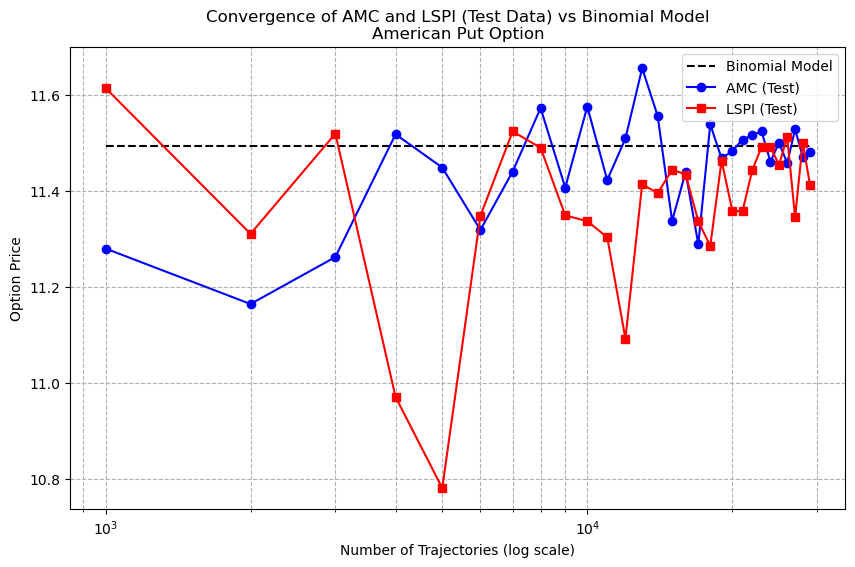

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

# Fixed option parameters (in-the-money American put)
cnt_trajectories_list = np.arange(1000, 30_000, 1000)

binomial_params = option_params.copy()
binomial_params["cnt_times"] = 1000 
_, binomial_price = price_gbm_put(**binomial_params)
binomial_price = binomial_price[0]

# Clear lists to avoid accumulation from previous runs
amc_prices = []
lspi_prices = []

# Compute prices for each number of trajectories
for idx, cnt_traj in enumerate(tqdm(cnt_trajectories_list, desc="Computing prices")):
    # Initialize sampler
    sampler = GeometricBrownianMotionPutSampler(
        cnt_trajectories=cnt_traj,
        seed=None,  # Random trajectories for train and test
        **option_params
    )

    # AMC pricing
    amc = PricerAmericanMonteCarlo(
        sampler=sampler,
        regularization_alpha=1e-3
    )
    amc.price(test = False, quiet = True)  # Train
    amc_price = amc.price(test=True, quiet=True)[0]  # Predict
    amc_prices.append(amc_price)
    print(f"AMC price at idx {idx}, cnt_traj {cnt_traj}: {amc_price}")

    # LSPI pricing
    pricer = LSPIPricer(sampler = sampler)
    pricer.price(test = False)  # Train
    pv_payoffs = pricer.price(test = True)  # Predict
    lspi_price = np.mean(pv_payoffs)
    lspi_prices.append(lspi_price)
    print(f"LSPI price at idx {idx}, cnt_traj {cnt_traj}: {lspi_price}")

# Debugging: Check lengths
print(f"Length of cnt_trajectories_list: {len(cnt_trajectories_list)}")
print(f"Length of amc_prices: {len(amc_prices)}")
print(f"Length of lspi_prices: {len(lspi_prices)}")

# Plotting only if lengths match
if len(cnt_trajectories_list) == len(amc_prices) == len(lspi_prices):
    plt.figure(figsize=(10, 6))
    plt.plot(cnt_trajectories_list, [binomial_price] * len(cnt_trajectories_list), 
             label='Binomial Model', linestyle='--', color='black')
    plt.plot(cnt_trajectories_list, amc_prices, 
             label='AMC (Test)', marker='o', color='blue')
    plt.plot(cnt_trajectories_list, lspi_prices, 
             label='LSPI (Test)', marker='s', color='red')

    plt.xscale('log')
    plt.xlabel('Number of Trajectories (log scale)')
    plt.ylabel('Option Price')
    plt.title('Convergence of AMC and LSPI (Test Data) vs Binomial Model\nAmerican Put Option')
    plt.legend()
    plt.grid(True, which="both", ls="--")

    # Save the plot
    plt.savefig('convergence_plot_corrected.png')
else:
    print("Error: Lengths of cnt_trajectories_list, amc_prices, and lspi_prices do not match!")

In [3]:
binomial_price

11.493479753324463

In [4]:
pricer.__dict__

{'iterations': 15,
 'tol': 1e-05,
 'lambda_reg': 0.01,
 'w': array([ 12.11860672, -34.15205971,  38.2339704 ,   3.44584888,
          2.6791155 ,   0.99065495,   2.97259807]),
 'sampler': <samplers.GeometricBrownianMotionPutSampler at 0x7d327f1682d0>}

## графики затухания

In [17]:
def evaluate_pricer_with_std(sampler_class, pricer_class, cnt_traj_list, num_repeats=10, **option_params):
    mean_prices = []
    std_prices = []
    
    for cnt_traj in cnt_traj_list:
        sampler = sampler_class(cnt_trajectories=cnt_traj, **option_params)
        pricer = pricer_class(sampler=sampler)
        prices = []
        
        for _ in range(num_repeats):
            pricer.price(test=False)
            pv_payoffs = pricer.price(test=True) 
            price = np.mean(pv_payoffs)
            prices.append(price)
        
        mean_price = np.mean(prices)
        std_price = np.std(prices)
        mean_prices.append(mean_price)
        std_prices.append(std_price)
        print(f"cnt_traj: {cnt_traj}, mean_price: {mean_price:.4f}, std_price: {std_price:.4f}")
    
    return mean_prices, std_prices

def plot_prices_with_std(cnt_traj_list, mean_prices, std_prices, label='LSPI', reference_price=None):
    plt.figure(figsize=(10, 6))
    plt.plot(cnt_traj_list, mean_prices, label=f'{label} средняя цена')
    plt.fill_between(cnt_traj_list, 
                     np.array(mean_prices) - np.array(std_prices), 
                     np.array(mean_prices) + np.array(std_prices), 
                     alpha=0.3, label=f'{label} стандартное отклонение')
    if reference_price is not None:
        plt.axhline(y=reference_price, color='r', linestyle='--', label='Биномиальная модель')
    plt.xscale('log')  # Устанавливаем логарифмическую шкалу для оси X
    plt.xlabel('Количество траекторий (логарифмическая шкала)')
    plt.ylabel('Цена опциона')
    plt.title('Сходимость цены опциона с учетом стандартного отклонения')
    plt.legend()
    plt.grid(True)
    plt.show() 

def plot_std_only(cnt_traj_list, std_prices, label='LSPI'):
    plt.figure(figsize=(10, 6))
    plt.plot(cnt_traj_list, std_prices, label=f'{label} стандартное отклонение', color='orange')
    plt.xscale('log')
    plt.xlabel('Количество траекторий (логарифмическая шкала)')
    plt.ylabel('Стандартное отклонение цены опциона')
    plt.title('Зависимость стандартного отклонения от количества траекторий')
    plt.legend()
    plt.grid(True)
    plt.show()

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 380.4439
на 1-ой итерации норма разности весов составила 535.4776
на 2-ой итерации норма разности весов составила 129.2889
на 3-ой итерации норма разности весов составила 56.9883
на 4-ой итерации норма разности весов составила 10.8605
на 5-ой итерации норма разности весов составила 4.4211
на 6-ой итерации норма разности весов составила 0.6284
на 7-ой итерации норма разности весов составила 0.2394
на 8-ой итерации норма разности весов составила 0.1183
на 9-ой итерации норма разности весов составила 0.0089
на 10-ой итерации норма разности весов составила 0.0005
на 11-ой итерации норма разности весов составила 0.0
на 12-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 8.0887
на 1-ой итерации норма разности весов составила 5.271
на 2-ой итерации норма разности весов составила 1.7306
на 3-ой итерации норма разности весов составила 0.4505
на 4-ой итерации норма разности весов составила 0.0602
на 5-ой итерации норма разности весов составила 0.0002
на 6-ой итерации норма разности весов составила 0.0
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 3.3255
на 1-ой итерации норма разности весов составила 5.8455
на 2-ой итерации норма разности весов составила 1.4486
на 3-ой итерации норма разности весов составила 0.2307
на 4-ой итерации норма разности весов составила 0.0032
на 5-ой итерации норма разности весов составила 0.0
на 6-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 3.5812
на 1-ой итерации норма разности весов составила 1.4569
на 2-ой итерации норма разности весов составила 0.2397
на 3-ой итерации норма разности весов составила 0.354
на 4-ой итерации норма разности весов составила 0.1085
на 5-ой итерации норма разности весов составила 0.001
на 6-ой итерации норма разности весов составила 0.0001
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 11.288
на 1-ой итерации норма разности весов составила 14.7448
на 2-ой итерации норма разности весов составила 11.1665
на 3-ой итерации норма разности весов составила 0.3289
на 4-ой итерации норма разности весов составила 0.106
на 5-ой итерации норма разности весов составила 0.0017
на 6-ой итерации норма разности весов составила 0.0001
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

cnt_traj: 1000, mean_price: 11.5105, std_price: 0.3598


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 649.8391
на 1-ой итерации норма разности весов составила 602.0974
на 2-ой итерации норма разности весов составила 76.9338
на 3-ой итерации норма разности весов составила 49.3538
на 4-ой итерации норма разности весов составила 4.0507
на 5-ой итерации норма разности весов составила 4.4342
на 6-ой итерации норма разности весов составила 1.415
на 7-ой итерации норма разности весов составила 0.4333
на 8-ой итерации норма разности весов составила 0.0249
на 9-ой итерации норма разности весов составила 0.0008
на 10-ой итерации норма разности весов составила 0.0
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 16.377
на 1-ой итерации норма разности весов составила 1.8769
на 2-ой итерации норма разности весов составила 1.0392
на 3-ой итерации норма разности весов составила 0.1362
на 4-ой итерации норма разности весов составила 0.0052
на 5-ой итерации норма разности весов составила 0.0004
на 6-ой итерации норма разности весов составила 0.0
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 39.5131
на 1-ой итерации норма разности весов составила 57.7844
на 2-ой итерации норма разности весов составила 51.5071
на 3-ой итерации норма разности весов составила 3.8012
на 4-ой итерации норма разности весов составила 0.1953
на 5-ой итерации норма разности весов составила 0.1601
на 6-ой итерации норма разности весов составила 0.009
на 7-ой итерации норма разности весов составила 0.0005
на 8-ой итерации норма разности весов составила 0.0
на 9-ой итерации норма разности весов составила 0.0
на 10-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 27.0831
на 1-ой итерации норма разности весов составила 10.5153
на 2-ой итерации норма разности весов составила 0.8709
на 3-ой итерации норма разности весов составила 0.2961
на 4-ой итерации норма разности весов составила 0.1025
на 5-ой итерации норма разности весов составила 0.0005
на 6-ой итерации норма разности весов составила 0.0
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 4.9913
на 1-ой итерации норма разности весов составила 4.5244
на 2-ой итерации норма разности весов составила 3.2338
на 3-ой итерации норма разности весов составила 0.5193
на 4-ой итерации норма разности весов составила 0.033
на 5-ой итерации норма разности весов составила 0.0005
на 6-ой итерации норма разности весов составила 0.0
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

cnt_traj: 2000, mean_price: 11.1787, std_price: 0.3981


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 734.7305
на 1-ой итерации норма разности весов составила 480.7246
на 2-ой итерации норма разности весов составила 148.8235
на 3-ой итерации норма разности весов составила 43.9018
на 4-ой итерации норма разности весов составила 14.034
на 5-ой итерации норма разности весов составила 10.0959
на 6-ой итерации норма разности весов составила 2.3326
на 7-ой итерации норма разности весов составила 0.5262
на 8-ой итерации норма разности весов составила 0.0448
на 9-ой итерации норма разности весов составила 0.0004
на 10-ой итерации норма разности весов составила 0.0
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 8.6296
на 1-ой итерации норма разности весов составила 0.4849
на 2-ой итерации норма разности весов составила 0.0432
на 3-ой итерации норма разности весов составила 0.0006
на 4-ой итерации норма разности весов составила 0.0
на 5-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 14.5945
на 1-ой итерации норма разности весов составила 1.077
на 2-ой итерации норма разности весов составила 0.3359
на 3-ой итерации норма разности весов составила 0.0185
на 4-ой итерации норма разности весов составила 0.0008
на 5-ой итерации норма разности весов составила 0.0
на 6-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 25.2087
на 1-ой итерации норма разности весов составила 1.21
на 2-ой итерации норма разности весов составила 0.2306
на 3-ой итерации норма разности весов составила 0.0061
на 4-ой итерации норма разности весов составила 0.0003
на 5-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 12.9437
на 1-ой итерации норма разности весов составила 4.7483
на 2-ой итерации норма разности весов составила 1.1323
на 3-ой итерации норма разности весов составила 0.0475
на 4-ой итерации норма разности весов составила 0.0007
на 5-ой итерации норма разности весов составила 0.0
на 6-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

cnt_traj: 3000, mean_price: 11.3452, std_price: 0.2562


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 834.0204
на 1-ой итерации норма разности весов составила 544.7722
на 2-ой итерации норма разности весов составила 145.7522
на 3-ой итерации норма разности весов составила 83.0904
на 4-ой итерации норма разности весов составила 19.6735
на 5-ой итерации норма разности весов составила 9.2139
на 6-ой итерации норма разности весов составила 3.5706
на 7-ой итерации норма разности весов составила 1.0053
на 8-ой итерации норма разности весов составила 0.0692
на 9-ой итерации норма разности весов составила 0.0009
на 10-ой итерации норма разности весов составила 0.0
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 28.816
на 1-ой итерации норма разности весов составила 15.6714
на 2-ой итерации норма разности весов составила 0.5186
на 3-ой итерации норма разности весов составила 0.1445
на 4-ой итерации норма разности весов составила 0.0101
на 5-ой итерации норма разности весов составила 0.0004
на 6-ой итерации норма разности весов составила 0.0
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 33.8678
на 1-ой итерации норма разности весов составила 50.5413
на 2-ой итерации норма разности весов составила 41.606
на 3-ой итерации норма разности весов составила 0.8693
на 4-ой итерации норма разности весов составила 0.544
на 5-ой итерации норма разности весов составила 0.0395
на 6-ой итерации норма разности весов составила 0.001
на 7-ой итерации норма разности весов составила 0.0001
на 8-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 8.2654
на 1-ой итерации норма разности весов составила 86.5455
на 2-ой итерации норма разности весов составила 83.5517
на 3-ой итерации норма разности весов составила 6.3942
на 4-ой итерации норма разности весов составила 0.5974
на 5-ой итерации норма разности весов составила 0.0285
на 6-ой итерации норма разности весов составила 0.0007
на 7-ой итерации норма разности весов составила 0.0
на 8-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 17.7212
на 1-ой итерации норма разности весов составила 1.194
на 2-ой итерации норма разности весов составила 0.4989
на 3-ой итерации норма разности весов составила 0.0404
на 4-ой итерации норма разности весов составила 0.001
на 5-ой итерации норма разности весов составила 0.0
на 6-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

cnt_traj: 4000, mean_price: 11.2192, std_price: 0.2991


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 870.1878
на 1-ой итерации норма разности весов составила 544.1017
на 2-ой итерации норма разности весов составила 162.3179
на 3-ой итерации норма разности весов составила 112.1599
на 4-ой итерации норма разности весов составила 27.8708
на 5-ой итерации норма разности весов составила 9.1831
на 6-ой итерации норма разности весов составила 3.3732
на 7-ой итерации норма разности весов составила 0.8492
на 8-ой итерации норма разности весов составила 0.0673
на 9-ой итерации норма разности весов составила 0.002
на 10-ой итерации норма разности весов составила 0.0001
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 3.1713
на 1-ой итерации норма разности весов составила 8.9879
на 2-ой итерации норма разности весов составила 7.0294
на 3-ой итерации норма разности весов составила 1.0594
на 4-ой итерации норма разности весов составила 0.0665
на 5-ой итерации норма разности весов составила 0.0005
на 6-ой итерации норма разности весов составила 0.0
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 14.2369
на 1-ой итерации норма разности весов составила 1.2094
на 2-ой итерации норма разности весов составила 0.0718
на 3-ой итерации норма разности весов составила 0.0011
на 4-ой итерации норма разности весов составила 0.0
на 5-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 4.0162
на 1-ой итерации норма разности весов составила 13.9689
на 2-ой итерации норма разности весов составила 9.4346
на 3-ой итерации норма разности весов составила 1.4194
на 4-ой итерации норма разности весов составила 0.1079
на 5-ой итерации норма разности весов составила 0.0006
на 6-ой итерации норма разности весов составила 0.0001
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 12.5803
на 1-ой итерации норма разности весов составила 18.5241
на 2-ой итерации норма разности весов составила 15.924
на 3-ой итерации норма разности весов составила 1.7523
на 4-ой итерации норма разности весов составила 0.223
на 5-ой итерации норма разности весов составила 0.0007
на 6-ой итерации норма разности весов составила 0.0
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

cnt_traj: 5000, mean_price: 11.3803, std_price: 0.1223


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 889.8973
на 1-ой итерации норма разности весов составила 539.5258
на 2-ой итерации норма разности весов составила 176.4319
на 3-ой итерации норма разности весов составила 132.2583
на 4-ой итерации норма разности весов составила 30.1933
на 5-ой итерации норма разности весов составила 8.4837
на 6-ой итерации норма разности весов составила 4.4593
на 7-ой итерации норма разности весов составила 1.1384
на 8-ой итерации норма разности весов составила 0.0713
на 9-ой итерации норма разности весов составила 0.0023
на 10-ой итерации норма разности весов составила 0.0001
на 11-ой итерации норма разности весов составила 0.0
на 12-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 28.7659
на 1-ой итерации норма разности весов составила 0.2893
на 2-ой итерации норма разности весов составила 0.0021
на 3-ой итерации норма разности весов составила 0.0001
на 4-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 35.4711
на 1-ой итерации норма разности весов составила 3.9465
на 2-ой итерации норма разности весов составила 0.088
на 3-ой итерации норма разности весов составила 0.0083
на 4-ой итерации норма разности весов составила 0.0004
на 5-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 54.9118
на 1-ой итерации норма разности весов составила 10.7476
на 2-ой итерации норма разности весов составила 10.5524
на 3-ой итерации норма разности весов составила 1.3911
на 4-ой итерации норма разности весов составила 0.1367
на 5-ой итерации норма разности весов составила 0.0012
на 6-ой итерации норма разности весов составила 0.0001
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 31.8565
на 1-ой итерации норма разности весов составила 15.7994
на 2-ой итерации норма разности весов составила 11.1614
на 3-ой итерации норма разности весов составила 1.559
на 4-ой итерации норма разности весов составила 0.1231
на 5-ой итерации норма разности весов составила 0.0004
на 6-ой итерации норма разности весов составила 0.0
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

cnt_traj: 6000, mean_price: 11.4613, std_price: 0.0925


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 950.572
на 1-ой итерации норма разности весов составила 516.0466
на 2-ой итерации норма разности весов составила 168.5218
на 3-ой итерации норма разности весов составила 149.8373
на 4-ой итерации норма разности весов составила 49.2274
на 5-ой итерации норма разности весов составила 14.073
на 6-ой итерации норма разности весов составила 7.5047
на 7-ой итерации норма разности весов составила 1.7489
на 8-ой итерации норма разности весов составила 0.1151
на 9-ой итерации норма разности весов составила 0.0021
на 10-ой итерации норма разности весов составила 0.0001
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 29.9722
на 1-ой итерации норма разности весов составила 0.2526
на 2-ой итерации норма разности весов составила 0.0011
на 3-ой итерации норма разности весов составила 0.0
на 4-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 7.8629
на 1-ой итерации норма разности весов составила 0.3698
на 2-ой итерации норма разности весов составила 0.0102
на 3-ой итерации норма разности весов составила 0.0002
на 4-ой итерации норма разности весов составила 0.0
на 5-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 2.1627
на 1-ой итерации норма разности весов составила 0.8912
на 2-ой итерации норма разности весов составила 0.3248
на 3-ой итерации норма разности весов составила 0.0144
на 4-ой итерации норма разности весов составила 0.0005
на 5-ой итерации норма разности весов составила 0.0
на 6-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 10.5227
на 1-ой итерации норма разности весов составила 4.5316
на 2-ой итерации норма разности весов составила 0.6949
на 3-ой итерации норма разности весов составила 0.0243
на 4-ой итерации норма разности весов составила 0.001
на 5-ой итерации норма разности весов составила 0.0001
на 6-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

cnt_traj: 7000, mean_price: 11.4520, std_price: 0.1140


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 967.7387
на 1-ой итерации норма разности весов составила 524.3507
на 2-ой итерации норма разности весов составила 157.1718
на 3-ой итерации норма разности весов составила 161.9262
на 4-ой итерации норма разности весов составила 54.0015
на 5-ой итерации норма разности весов составила 15.2485
на 6-ой итерации норма разности весов составила 7.9881
на 7-ой итерации норма разности весов составила 1.7699
на 8-ой итерации норма разности весов составила 0.1252
на 9-ой итерации норма разности весов составила 0.0021
на 10-ой итерации норма разности весов составила 0.0
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 36.1774
на 1-ой итерации норма разности весов составила 40.9644
на 2-ой итерации норма разности весов составила 36.6925
на 3-ой итерации норма разности весов составила 0.789
на 4-ой итерации норма разности весов составила 0.4708
на 5-ой итерации норма разности весов составила 0.0013
на 6-ой итерации норма разности весов составила 0.0
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 43.4781
на 1-ой итерации норма разности весов составила 17.9832
на 2-ой итерации норма разности весов составила 0.421
на 3-ой итерации норма разности весов составила 0.2143
на 4-ой итерации норма разности весов составила 0.0101
на 5-ой итерации норма разности весов составила 0.0005
на 6-ой итерации норма разности весов составила 0.0
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 30.5792
на 1-ой итерации норма разности весов составила 27.6888
на 2-ой итерации норма разности весов составила 26.4813
на 3-ой итерации норма разности весов составила 1.0345
на 4-ой итерации норма разности весов составила 0.2989
на 5-ой итерации норма разности весов составила 0.0008
на 6-ой итерации норма разности весов составила 0.0001
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 47.9371
на 1-ой итерации норма разности весов составила 5.368
на 2-ой итерации норма разности весов составила 0.1258
на 3-ой итерации норма разности весов составила 0.0177
на 4-ой итерации норма разности весов составила 0.0007
на 5-ой итерации норма разности весов составила 0.0
на 6-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

cnt_traj: 8000, mean_price: 11.4609, std_price: 0.0313


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 969.6209
на 1-ой итерации норма разности весов составила 499.8509
на 2-ой итерации норма разности весов составила 162.4079
на 3-ой итерации норма разности весов составила 198.7325
на 4-ой итерации норма разности весов составила 64.1717
на 5-ой итерации норма разности весов составила 12.272
на 6-ой итерации норма разности весов составила 8.5597
на 7-ой итерации норма разности весов составила 1.8228
на 8-ой итерации норма разности весов составила 0.0903
на 9-ой итерации норма разности весов составила 0.0014
на 10-ой итерации норма разности весов составила 0.0
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 12.069
на 1-ой итерации норма разности весов составила 5.3122
на 2-ой итерации норма разности весов составила 0.7224
на 3-ой итерации норма разности весов составила 0.5603
на 4-ой итерации норма разности весов составила 0.0175
на 5-ой итерации норма разности весов составила 0.0004
на 6-ой итерации норма разности весов составила 0.0
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 14.0887
на 1-ой итерации норма разности весов составила 29.8527
на 2-ой итерации норма разности весов составила 23.7858
на 3-ой итерации норма разности весов составила 1.598
на 4-ой итерации норма разности весов составила 0.2727
на 5-ой итерации норма разности весов составила 0.0004
на 6-ой итерации норма разности весов составила 0.0
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 18.7394
на 1-ой итерации норма разности весов составила 2.3713
на 2-ой итерации норма разности весов составила 0.3807
на 3-ой итерации норма разности весов составила 0.0764
на 4-ой итерации норма разности весов составила 0.0018
на 5-ой итерации норма разности весов составила 0.0001
на 6-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 34.0275
на 1-ой итерации норма разности весов составила 5.4062
на 2-ой итерации норма разности весов составила 4.6596
на 3-ой итерации норма разности весов составила 1.0502
на 4-ой итерации норма разности весов составила 0.0471
на 5-ой итерации норма разности весов составила 0.0003
на 6-ой итерации норма разности весов составила 0.0
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

cnt_traj: 9000, mean_price: 11.4048, std_price: 0.1614


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 996.9385
на 1-ой итерации норма разности весов составила 537.5193
на 2-ой итерации норма разности весов составила 169.6509
на 3-ой итерации норма разности весов составила 177.4462
на 4-ой итерации норма разности весов составила 57.979
на 5-ой итерации норма разности весов составила 13.1184
на 6-ой итерации норма разности весов составила 9.2921
на 7-ой итерации норма разности весов составила 1.8887
на 8-ой итерации норма разности весов составила 0.1366
на 9-ой итерации норма разности весов составила 0.002
на 10-ой итерации норма разности весов составила 0.0
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 26.8212
на 1-ой итерации норма разности весов составила 2.7852
на 2-ой итерации норма разности весов составила 0.1336
на 3-ой итерации норма разности весов составила 0.0016
на 4-ой итерации норма разности весов составила 0.0001
на 5-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 10.9947
на 1-ой итерации норма разности весов составила 1.6455
на 2-ой итерации норма разности весов составила 0.0126
на 3-ой итерации норма разности весов составила 0.0001
на 4-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 17.2186
на 1-ой итерации норма разности весов составила 4.6445
на 2-ой итерации норма разности весов составила 0.0686
на 3-ой итерации норма разности весов составила 0.0007
на 4-ой итерации норма разности весов составила 0.0
на 5-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 36.6695
на 1-ой итерации норма разности весов составила 2.2383
на 2-ой итерации норма разности весов составила 1.9729
на 3-ой итерации норма разности весов составила 0.5692
на 4-ой итерации норма разности весов составила 0.0165
на 5-ой итерации норма разности весов составила 0.0003
на 6-ой итерации норма разности весов составила 0.0
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

cnt_traj: 10000, mean_price: 11.4000, std_price: 0.1045


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 1031.0806
на 1-ой итерации норма разности весов составила 551.458
на 2-ой итерации норма разности весов составила 149.9602
на 3-ой итерации норма разности весов составила 184.3469
на 4-ой итерации норма разности весов составила 66.1333
на 5-ой итерации норма разности весов составила 16.4688
на 6-ой итерации норма разности весов составила 9.0321
на 7-ой итерации норма разности весов составила 2.1524
на 8-ой итерации норма разности весов составила 0.1836
на 9-ой итерации норма разности весов составила 0.0034
на 10-ой итерации норма разности весов составила 0.0001
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 14.1506
на 1-ой итерации норма разности весов составила 1.6122
на 2-ой итерации норма разности весов составила 0.036
на 3-ой итерации норма разности весов составила 0.0017
на 4-ой итерации норма разности весов составила 0.0001
на 5-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 4.788
на 1-ой итерации норма разности весов составила 8.5054
на 2-ой итерации норма разности весов составила 6.8312
на 3-ой итерации норма разности весов составила 1.3443
на 4-ой итерации норма разности весов составила 0.072
на 5-ой итерации норма разности весов составила 0.0005
на 6-ой итерации норма разности весов составила 0.0
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 17.7876
на 1-ой итерации норма разности весов составила 1.7804
на 2-ой итерации норма разности весов составила 0.3934
на 3-ой итерации норма разности весов составила 0.0046
на 4-ой итерации норма разности весов составила 0.0001
на 5-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 2.6961
на 1-ой итерации норма разности весов составила 7.6817
на 2-ой итерации норма разности весов составила 1.6795
на 3-ой итерации норма разности весов составила 0.0402
на 4-ой итерации норма разности весов составила 0.0007
на 5-ой итерации норма разности весов составила 0.0
на 6-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

cnt_traj: 11000, mean_price: 11.3732, std_price: 0.1144


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 978.5337
на 1-ой итерации норма разности весов составила 499.5362
на 2-ой итерации норма разности весов составила 162.2848
на 3-ой итерации норма разности весов составила 197.9213
на 4-ой итерации норма разности весов составила 66.3048
на 5-ой итерации норма разности весов составила 14.6879
на 6-ой итерации норма разности весов составила 8.2884
на 7-ой итерации норма разности весов составила 2.0498
на 8-ой итерации норма разности весов составила 0.1612
на 9-ой итерации норма разности весов составила 0.0029
на 10-ой итерации норма разности весов составила 0.0001
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 20.1112
на 1-ой итерации норма разности весов составила 9.8226
на 2-ой итерации норма разности весов составила 7.3229
на 3-ой итерации норма разности весов составила 1.4305
на 4-ой итерации норма разности весов составила 0.0987
на 5-ой итерации норма разности весов составила 0.0008
на 6-ой итерации норма разности весов составила 0.0001
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 42.4974
на 1-ой итерации норма разности весов составила 0.1997
на 2-ой итерации норма разности весов составила 0.0018
на 3-ой итерации норма разности весов составила 0.0
на 4-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 17.1929
на 1-ой итерации норма разности весов составила 0.4483
на 2-ой итерации норма разности весов составила 0.0014
на 3-ой итерации норма разности весов составила 0.0
на 4-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 43.0606
на 1-ой итерации норма разности весов составила 13.7325
на 2-ой итерации норма разности весов составила 9.6344
на 3-ой итерации норма разности весов составила 1.6523
на 4-ой итерации норма разности весов составила 0.1046
на 5-ой итерации норма разности весов составила 0.0005
на 6-ой итерации норма разности весов составила 0.0
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

cnt_traj: 12000, mean_price: 11.4317, std_price: 0.1287


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 959.7316
на 1-ой итерации норма разности весов составила 491.5447
на 2-ой итерации норма разности весов составила 158.7558
на 3-ой итерации норма разности весов составила 188.2805
на 4-ой итерации норма разности весов составила 69.5776
на 5-ой итерации норма разности весов составила 18.1318
на 6-ой итерации норма разности весов составила 9.571
на 7-ой итерации норма разности весов составила 2.2334
на 8-ой итерации норма разности весов составила 0.1569
на 9-ой итерации норма разности весов составила 0.0027
на 10-ой итерации норма разности весов составила 0.0
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 43.9807
на 1-ой итерации норма разности весов составила 12.4953
на 2-ой итерации норма разности весов составила 1.051
на 3-ой итерации норма разности весов составила 0.3708
на 4-ой итерации норма разности весов составила 0.0471
на 5-ой итерации норма разности весов составила 0.002
на 6-ой итерации норма разности весов составила 0.0001
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 16.562
на 1-ой итерации норма разности весов составила 0.1686
на 2-ой итерации норма разности весов составила 0.0029
на 3-ой итерации норма разности весов составила 0.0001
на 4-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 46.7386
на 1-ой итерации норма разности весов составила 30.899
на 2-ой итерации норма разности весов составила 25.3128
на 3-ой итерации норма разности весов составила 2.8315
на 4-ой итерации норма разности весов составила 0.4274
на 5-ой итерации норма разности весов составила 0.0013
на 6-ой итерации норма разности весов составила 0.0
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 23.7262
на 1-ой итерации норма разности весов составила 2.959
на 2-ой итерации норма разности весов составила 0.2674
на 3-ой итерации норма разности весов составила 0.0002
на 4-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

cnt_traj: 13000, mean_price: 11.4281, std_price: 0.0522


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 1061.4686
на 1-ой итерации норма разности весов составила 539.3621
на 2-ой итерации норма разности весов составила 157.8289
на 3-ой итерации норма разности весов составила 218.9282
на 4-ой итерации норма разности весов составила 77.0207
на 5-ой итерации норма разности весов составила 17.3438
на 6-ой итерации норма разности весов составила 10.444
на 7-ой итерации норма разности весов составила 2.5541
на 8-ой итерации норма разности весов составила 0.1997
на 9-ой итерации норма разности весов составила 0.0039
на 10-ой итерации норма разности весов составила 0.0001
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 11.3264
на 1-ой итерации норма разности весов составила 0.2213
на 2-ой итерации норма разности весов составила 0.0014
на 3-ой итерации норма разности весов составила 0.0001
на 4-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 5.4741
на 1-ой итерации норма разности весов составила 0.1017
на 2-ой итерации норма разности весов составила 0.0053
на 3-ой итерации норма разности весов составила 0.0003
на 4-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 5.9477
на 1-ой итерации норма разности весов составила 0.9796
на 2-ой итерации норма разности весов составила 0.027
на 3-ой итерации норма разности весов составила 0.0014
на 4-ой итерации норма разности весов составила 0.0001
на 5-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 21.9381
на 1-ой итерации норма разности весов составила 7.9795
на 2-ой итерации норма разности весов составила 0.4056
на 3-ой итерации норма разности весов составила 0.0508
на 4-ой итерации норма разности весов составила 0.0021
на 5-ой итерации норма разности весов составила 0.0002
на 6-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

cnt_traj: 14000, mean_price: 11.4313, std_price: 0.0766


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 1052.7888
на 1-ой итерации норма разности весов составила 498.2277
на 2-ой итерации норма разности весов составила 161.2853
на 3-ой итерации норма разности весов составила 231.0108
на 4-ой итерации норма разности весов составила 85.3588
на 5-ой итерации норма разности весов составила 19.8691
на 6-ой итерации норма разности весов составила 11.911
на 7-ой итерации норма разности весов составила 2.7355
на 8-ой итерации норма разности весов составила 0.2539
на 9-ой итерации норма разности весов составила 0.0033
на 10-ой итерации норма разности весов составила 0.0001
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 1.9048
на 1-ой итерации норма разности весов составила 4.92
на 2-ой итерации норма разности весов составила 0.2068
на 3-ой итерации норма разности весов составила 0.0025
на 4-ой итерации норма разности весов составила 0.0001
на 5-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 9.1379
на 1-ой итерации норма разности весов составила 1.1428
на 2-ой итерации норма разности весов составила 0.5347
на 3-ой итерации норма разности весов составила 0.0442
на 4-ой итерации норма разности весов составила 0.0017
на 5-ой итерации норма разности весов составила 0.0001
на 6-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 20.4839
на 1-ой итерации норма разности весов составила 8.1534
на 2-ой итерации норма разности весов составила 7.2073
на 3-ой итерации норма разности весов составила 1.2766
на 4-ой итерации норма разности весов составила 0.0639
на 5-ой итерации норма разности весов составила 0.0005
на 6-ой итерации норма разности весов составила 0.0
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 58.7673
на 1-ой итерации норма разности весов составила 2.1536
на 2-ой итерации норма разности весов составила 0.0163
на 3-ой итерации норма разности весов составила 0.0007
на 4-ой итерации норма разности весов составила 0.0
на 5-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

cnt_traj: 15000, mean_price: 11.3743, std_price: 0.1143


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 1007.163
на 1-ой итерации норма разности весов составила 511.0405
на 2-ой итерации норма разности весов составила 169.5334
на 3-ой итерации норма разности весов составила 206.9177
на 4-ой итерации норма разности весов составила 72.7144
на 5-ой итерации норма разности весов составила 16.0966
на 6-ой итерации норма разности весов составила 10.6303
на 7-ой итерации норма разности весов составила 2.4649
на 8-ой итерации норма разности весов составила 0.1483
на 9-ой итерации норма разности весов составила 0.0013
на 10-ой итерации норма разности весов составила 0.0
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 26.534
на 1-ой итерации норма разности весов составила 1.2659
на 2-ой итерации норма разности весов составила 0.0244
на 3-ой итерации норма разности весов составила 0.0001
на 4-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 0.503
на 1-ой итерации норма разности весов составила 0.3783
на 2-ой итерации норма разности весов составила 0.003
на 3-ой итерации норма разности весов составила 0.0003
на 4-ой итерации норма разности весов составила 0.0
на 5-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 21.2757
на 1-ой итерации норма разности весов составила 0.3792
на 2-ой итерации норма разности весов составила 0.0025
на 3-ой итерации норма разности весов составила 0.0
на 4-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 22.008
на 1-ой итерации норма разности весов составила 17.9234
на 2-ой итерации норма разности весов составила 14.7758
на 3-ой итерации норма разности весов составила 2.2411
на 4-ой итерации норма разности весов составила 0.192
на 5-ой итерации норма разности весов составила 0.0006
на 6-ой итерации норма разности весов составила 0.0
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

cnt_traj: 16000, mean_price: 11.4750, std_price: 0.0731


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 1053.252
на 1-ой итерации норма разности весов составила 498.8105
на 2-ой итерации норма разности весов составила 141.901
на 3-ой итерации норма разности весов составила 227.0038
на 4-ой итерации норма разности весов составила 93.3857
на 5-ой итерации норма разности весов составила 20.3738
на 6-ой итерации норма разности весов составила 12.111
на 7-ой итерации норма разности весов составила 2.8739
на 8-ой итерации норма разности весов составила 0.2181
на 9-ой итерации норма разности весов составила 0.0037
на 10-ой итерации норма разности весов составила 0.0001
на 11-ой итерации норма разности весов составила 0.0
на 12-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 19.221
на 1-ой итерации норма разности весов составила 0.2977
на 2-ой итерации норма разности весов составила 0.0105
на 3-ой итерации норма разности весов составила 0.0013
на 4-ой итерации норма разности весов составила 0.0
на 5-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 19.8583
на 1-ой итерации норма разности весов составила 0.0759
на 2-ой итерации норма разности весов составила 0.0003
на 3-ой итерации норма разности весов составила 0.0
на 4-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 7.5936
на 1-ой итерации норма разности весов составила 1.7586
на 2-ой итерации норма разности весов составила 0.463
на 3-ой итерации норма разности весов составила 0.0334
на 4-ой итерации норма разности весов составила 0.0013
на 5-ой итерации норма разности весов составила 0.0001
на 6-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 19.5524
на 1-ой итерации норма разности весов составила 7.454
на 2-ой итерации норма разности весов составила 7.3704
на 3-ой итерации норма разности весов составила 1.2508
на 4-ой итерации норма разности весов составила 0.0636
на 5-ой итерации норма разности весов составила 0.0004
на 6-ой итерации норма разности весов составила 0.0
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

cnt_traj: 17000, mean_price: 11.3370, std_price: 0.0742


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 1039.5479
на 1-ой итерации норма разности весов составила 533.722
на 2-ой итерации норма разности весов составила 154.2132
на 3-ой итерации норма разности весов составила 214.7448
на 4-ой итерации норма разности весов составила 78.8286
на 5-ой итерации норма разности весов составила 17.9424
на 6-ой итерации норма разности весов составила 11.3801
на 7-ой итерации норма разности весов составила 2.8034
на 8-ой итерации норма разности весов составила 0.2229
на 9-ой итерации норма разности весов составила 0.004
на 10-ой итерации норма разности весов составила 0.0001
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 1.0858
на 1-ой итерации норма разности весов составила 5.6222
на 2-ой итерации норма разности весов составила 0.1658
на 3-ой итерации норма разности весов составила 0.0214
на 4-ой итерации норма разности весов составила 0.001
на 5-ой итерации норма разности весов составила 0.0
на 6-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 26.5746
на 1-ой итерации норма разности весов составила 1.2291
на 2-ой итерации норма разности весов составила 0.2747
на 3-ой итерации норма разности весов составила 0.0358
на 4-ой итерации норма разности весов составила 0.0012
на 5-ой итерации норма разности весов составила 0.0001
на 6-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 17.6605
на 1-ой итерации норма разности весов составила 3.812
на 2-ой итерации норма разности весов составила 0.064
на 3-ой итерации норма разности весов составила 0.0007
на 4-ой итерации норма разности весов составила 0.0001
на 5-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 29.1532
на 1-ой итерации норма разности весов составила 0.7073
на 2-ой итерации норма разности весов составила 0.1297
на 3-ой итерации норма разности весов составила 0.0027
на 4-ой итерации норма разности весов составила 0.0
на 5-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

cnt_traj: 18000, mean_price: 11.5042, std_price: 0.0760


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 1091.1796
на 1-ой итерации норма разности весов составила 511.0043
на 2-ой итерации норма разности весов составила 141.4573
на 3-ой итерации норма разности весов составила 228.4225
на 4-ой итерации норма разности весов составила 98.1937
на 5-ой итерации норма разности весов составила 20.6633
на 6-ой итерации норма разности весов составила 12.6708
на 7-ой итерации норма разности весов составила 2.9849
на 8-ой итерации норма разности весов составила 0.2616
на 9-ой итерации норма разности весов составила 0.0049
на 10-ой итерации норма разности весов составила 0.0
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 13.4655
на 1-ой итерации норма разности весов составила 7.1108
на 2-ой итерации норма разности весов составила 4.7354
на 3-ой итерации норма разности весов составила 0.9192
на 4-ой итерации норма разности весов составила 0.0316
на 5-ой итерации норма разности весов составила 0.0004
на 6-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 16.219
на 1-ой итерации норма разности весов составила 14.1151
на 2-ой итерации норма разности весов составила 5.6815
на 3-ой итерации норма разности весов составила 1.933
на 4-ой итерации норма разности весов составила 0.1343
на 5-ой итерации норма разности весов составила 0.0018
на 6-ой итерации норма разности весов составила 0.0
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 32.1397
на 1-ой итерации норма разности весов составила 0.4987
на 2-ой итерации норма разности весов составила 0.0429
на 3-ой итерации норма разности весов составила 0.0006
на 4-ой итерации норма разности весов составила 0.0001
на 5-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 39.6239
на 1-ой итерации норма разности весов составила 1.6869
на 2-ой итерации норма разности весов составила 0.0072
на 3-ой итерации норма разности весов составила 0.0001
на 4-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

cnt_traj: 19000, mean_price: 11.4625, std_price: 0.0552


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 1086.6054
на 1-ой итерации норма разности весов составила 539.1879
на 2-ой итерации норма разности весов составила 157.9683
на 3-ой итерации норма разности весов составила 222.4191
на 4-ой итерации норма разности весов составила 87.3369
на 5-ой итерации норма разности весов составила 18.0444
на 6-ой итерации норма разности весов составила 11.9437
на 7-ой итерации норма разности весов составила 2.8442
на 8-ой итерации норма разности весов составила 0.2202
на 9-ой итерации норма разности весов составила 0.0037
на 10-ой итерации норма разности весов составила 0.0001
на 11-ой итерации норма разности весов составила 0.0
на 12-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 3.264
на 1-ой итерации норма разности весов составила 0.0482
на 2-ой итерации норма разности весов составила 0.0049
на 3-ой итерации норма разности весов составила 0.0
на 4-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 32.1163
на 1-ой итерации норма разности весов составила 1.4086
на 2-ой итерации норма разности весов составила 0.077
на 3-ой итерации норма разности весов составила 0.0007
на 4-ой итерации норма разности весов составила 0.0
на 5-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 14.6595
на 1-ой итерации норма разности весов составила 6.4417
на 2-ой итерации норма разности весов составила 2.2032
на 3-ой итерации норма разности весов составила 0.8459
на 4-ой итерации норма разности весов составила 0.0478
на 5-ой итерации норма разности весов составила 0.0012
на 6-ой итерации норма разности весов составила 0.0001
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 12.2468
на 1-ой итерации норма разности весов составила 2.7503
на 2-ой итерации норма разности весов составила 0.0854
на 3-ой итерации норма разности весов составила 0.001
на 4-ой итерации норма разности весов составила 0.0
на 5-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

cnt_traj: 20000, mean_price: 11.4357, std_price: 0.0448


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 1042.0769
на 1-ой итерации норма разности весов составила 504.39
на 2-ой итерации норма разности весов составила 154.9533
на 3-ой итерации норма разности весов составила 220.0927
на 4-ой итерации норма разности весов составила 85.7626
на 5-ой итерации норма разности весов составила 19.4891
на 6-ой итерации норма разности весов составила 12.6646
на 7-ой итерации норма разности весов составила 2.8689
на 8-ой итерации норма разности весов составила 0.2145
на 9-ой итерации норма разности весов составила 0.0042
на 10-ой итерации норма разности весов составила 0.0001
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 9.6712
на 1-ой итерации норма разности весов составила 4.2385
на 2-ой итерации норма разности весов составила 0.7351
на 3-ой итерации норма разности весов составила 0.4475
на 4-ой итерации норма разности весов составила 0.0023
на 5-ой итерации норма разности весов составила 0.0001
на 6-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 1.6019
на 1-ой итерации норма разности весов составила 0.0235
на 2-ой итерации норма разности весов составила 0.0013
на 3-ой итерации норма разности весов составила 0.0
на 4-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 15.4707
на 1-ой итерации норма разности весов составила 1.1706
на 2-ой итерации норма разности весов составила 0.1847
на 3-ой итерации норма разности весов составила 0.0013
на 4-ой итерации норма разности весов составила 0.0
на 5-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 16.5596
на 1-ой итерации норма разности весов составила 3.0147
на 2-ой итерации норма разности весов составила 0.3475
на 3-ой итерации норма разности весов составила 0.0003
на 4-ой итерации норма разности весов составила 0.0
на 5-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

cnt_traj: 21000, mean_price: 11.4409, std_price: 0.0914


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 1082.9772
на 1-ой итерации норма разности весов составила 506.0724
на 2-ой итерации норма разности весов составила 148.7638
на 3-ой итерации норма разности весов составила 234.1124
на 4-ой итерации норма разности весов составила 97.2236
на 5-ой итерации норма разности весов составила 21.2063
на 6-ой итерации норма разности весов составила 12.9743
на 7-ой итерации норма разности весов составила 3.2108
на 8-ой итерации норма разности весов составила 0.2701
на 9-ой итерации норма разности весов составила 0.0039
на 10-ой итерации норма разности весов составила 0.0
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 12.9671
на 1-ой итерации норма разности весов составила 8.8211
на 2-ой итерации норма разности весов составила 4.4332
на 3-ой итерации норма разности весов составила 1.3046
на 4-ой итерации норма разности весов составила 0.0488
на 5-ой итерации норма разности весов составила 0.0004
на 6-ой итерации норма разности весов составила 0.0
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 24.1258
на 1-ой итерации норма разности весов составила 0.2154
на 2-ой итерации норма разности весов составила 0.0011
на 3-ой итерации норма разности весов составила 0.0001
на 4-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 37.598
на 1-ой итерации норма разности весов составила 0.063
на 2-ой итерации норма разности весов составила 0.0006
на 3-ой итерации норма разности весов составила 0.0
на 4-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 21.616
на 1-ой итерации норма разности весов составила 1.2493
на 2-ой итерации норма разности весов составила 0.02
на 3-ой итерации норма разности весов составила 0.0011
на 4-ой итерации норма разности весов составила 0.0
на 5-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

cnt_traj: 22000, mean_price: 11.4289, std_price: 0.0418


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 1031.5733
на 1-ой итерации норма разности весов составила 485.1144
на 2-ой итерации норма разности весов составила 151.9689
на 3-ой итерации норма разности весов составила 228.8897
на 4-ой итерации норма разности весов составила 89.6992
на 5-ой итерации норма разности весов составила 19.7878
на 6-ой итерации норма разности весов составила 12.0831
на 7-ой итерации норма разности весов составила 3.1193
на 8-ой итерации норма разности весов составила 0.2551
на 9-ой итерации норма разности весов составила 0.0043
на 10-ой итерации норма разности весов составила 0.0001
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 3.3988
на 1-ой итерации норма разности весов составила 20.8661
на 2-ой итерации норма разности весов составила 15.0344
на 3-ой итерации норма разности весов составила 1.9932
на 4-ой итерации норма разности весов составила 0.1727
на 5-ой итерации норма разности весов составила 0.0008
на 6-ой итерации норма разности весов составила 0.0
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 6.051
на 1-ой итерации норма разности весов составила 0.3713
на 2-ой итерации норма разности весов составила 0.0006
на 3-ой итерации норма разности весов составила 0.0
на 4-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 0.3549
на 1-ой итерации норма разности весов составила 2.6344
на 2-ой итерации норма разности весов составила 0.5301
на 3-ой итерации норма разности весов составила 0.024
на 4-ой итерации норма разности весов составила 0.0006
на 5-ой итерации норма разности весов составила 0.0
на 6-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 12.2085
на 1-ой итерации норма разности весов составила 18.1668
на 2-ой итерации норма разности весов составила 11.1157
на 3-ой итерации норма разности весов составила 2.223
на 4-ой итерации норма разности весов составила 0.1418
на 5-ой итерации норма разности весов составила 0.001
на 6-ой итерации норма разности весов составила 0.0
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

cnt_traj: 23000, mean_price: 11.4102, std_price: 0.0784


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 1097.4836
на 1-ой итерации норма разности весов составила 530.5019
на 2-ой итерации норма разности весов составила 146.869
на 3-ой итерации норма разности весов составила 238.2546
на 4-ой итерации норма разности весов составила 94.1793
на 5-ой итерации норма разности весов составила 19.3468
на 6-ой итерации норма разности весов составила 13.1681
на 7-ой итерации норма разности весов составила 3.0519
на 8-ой итерации норма разности весов составила 0.2406
на 9-ой итерации норма разности весов составила 0.0038
на 10-ой итерации норма разности весов составила 0.0001
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 5.2562
на 1-ой итерации норма разности весов составила 0.0538
на 2-ой итерации норма разности весов составила 0.0017
на 3-ой итерации норма разности весов составила 0.0
на 4-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 20.0793
на 1-ой итерации норма разности весов составила 12.2459
на 2-ой итерации норма разности весов составила 11.8742
на 3-ой итерации норма разности весов составила 1.7462
на 4-ой итерации норма разности весов составила 0.1274
на 5-ой итерации норма разности весов составила 0.0006
на 6-ой итерации норма разности весов составила 0.0
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 27.0375
на 1-ой итерации норма разности весов составила 15.3409
на 2-ой итерации норма разности весов составила 13.5646
на 3-ой итерации норма разности весов составила 2.3434
на 4-ой итерации норма разности весов составила 0.1757
на 5-ой итерации норма разности весов составила 0.0006
на 6-ой итерации норма разности весов составила 0.0001
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 53.0552
на 1-ой итерации норма разности весов составила 1.2282
на 2-ой итерации норма разности весов составила 0.3495
на 3-ой итерации норма разности весов составила 0.0413
на 4-ой итерации норма разности весов составила 0.0013
на 5-ой итерации норма разности весов составила 0.0001
на 6-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

cnt_traj: 24000, mean_price: 11.4208, std_price: 0.0478


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 1085.9433
на 1-ой итерации норма разности весов составила 529.0122
на 2-ой итерации норма разности весов составила 155.8081
на 3-ой итерации норма разности весов составила 239.2329
на 4-ой итерации норма разности весов составила 93.0126
на 5-ой итерации норма разности весов составила 18.63
на 6-ой итерации норма разности весов составила 12.7447
на 7-ой итерации норма разности весов составила 3.1586
на 8-ой итерации норма разности весов составила 0.2802
на 9-ой итерации норма разности весов составила 0.0039
на 10-ой итерации норма разности весов составила 0.0001
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 24.8866
на 1-ой итерации норма разности весов составила 0.4908
на 2-ой итерации норма разности весов составила 0.0028
на 3-ой итерации норма разности весов составила 0.0001
на 4-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 1.1531
на 1-ой итерации норма разности весов составила 0.8617
на 2-ой итерации норма разности весов составила 0.3535
на 3-ой итерации норма разности весов составила 0.0256
на 4-ой итерации норма разности весов составила 0.0009
на 5-ой итерации норма разности весов составила 0.0001
на 6-ой итерации норма разности весов составила 0.0
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 20.5495
на 1-ой итерации норма разности весов составила 17.9237
на 2-ой итерации норма разности весов составила 14.4921
на 3-ой итерации норма разности весов составила 1.804
на 4-ой итерации норма разности весов составила 0.1461
на 5-ой итерации норма разности весов составила 0.0007
на 6-ой итерации норма разности весов составила 0.0001
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 31.9698
на 1-ой итерации норма разности весов составила 0.5953
на 2-ой итерации норма разности весов составила 0.0059
на 3-ой итерации норма разности весов составила 0.0
на 4-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

cnt_traj: 25000, mean_price: 11.4309, std_price: 0.0415


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 1120.3404
на 1-ой итерации норма разности весов составила 549.3353
на 2-ой итерации норма разности весов составила 153.4676
на 3-ой итерации норма разности весов составила 228.5374
на 4-ой итерации норма разности весов составила 94.1239
на 5-ой итерации норма разности весов составила 21.4866
на 6-ой итерации норма разности весов составила 14.5379
на 7-ой итерации норма разности весов составила 3.5584
на 8-ой итерации норма разности весов составила 0.2893
на 9-ой итерации норма разности весов составила 0.0045
на 10-ой итерации норма разности весов составила 0.0001
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 24.4707
на 1-ой итерации норма разности весов составила 11.4599
на 2-ой итерации норма разности весов составила 0.7382
на 3-ой итерации норма разности весов составила 0.275
на 4-ой итерации норма разности весов составила 0.0119
на 5-ой итерации норма разности весов составила 0.0005
на 6-ой итерации норма разности весов составила 0.0
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 45.1501
на 1-ой итерации норма разности весов составила 8.2167
на 2-ой итерации норма разности весов составила 6.5708
на 3-ой итерации норма разности весов составила 1.4477
на 4-ой итерации норма разности весов составила 0.0652
на 5-ой итерации норма разности весов составила 0.0004
на 6-ой итерации норма разности весов составила 0.0
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 36.5949
на 1-ой итерации норма разности весов составила 0.5952
на 2-ой итерации норма разности весов составила 0.002
на 3-ой итерации норма разности весов составила 0.0
на 4-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 21.3587
на 1-ой итерации норма разности весов составила 1.3586
на 2-ой итерации норма разности весов составила 0.035
на 3-ой итерации норма разности весов составила 0.0019
на 4-ой итерации норма разности весов составила 0.0001
на 5-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

cnt_traj: 26000, mean_price: 11.4050, std_price: 0.0791


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 1101.0558
на 1-ой итерации норма разности весов составила 535.848
на 2-ой итерации норма разности весов составила 155.4005
на 3-ой итерации норма разности весов составила 232.977
на 4-ой итерации норма разности весов составила 94.2294
на 5-ой итерации норма разности весов составила 21.304
на 6-ой итерации норма разности весов составила 13.7916
на 7-ой итерации норма разности весов составила 3.3477
на 8-ой итерации норма разности весов составила 0.3117
на 9-ой итерации норма разности весов составила 0.0064
на 10-ой итерации норма разности весов составила 0.0001
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 16.3758
на 1-ой итерации норма разности весов составила 3.0213
на 2-ой итерации норма разности весов составила 0.0241
на 3-ой итерации норма разности весов составила 0.0003
на 4-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 4.246
на 1-ой итерации норма разности весов составила 3.6544
на 2-ой итерации норма разности весов составила 0.5217
на 3-ой итерации норма разности весов составила 0.0059
на 4-ой итерации норма разности весов составила 0.0003
на 5-ой итерации норма разности весов составила 0.0
на 6-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 3.417
на 1-ой итерации норма разности весов составила 24.1897
на 2-ой итерации норма разности весов составила 19.1296
на 3-ой итерации норма разности весов составила 2.3246
на 4-ой итерации норма разности весов составила 0.2243
на 5-ой итерации норма разности весов составила 0.0007
на 6-ой итерации норма разности весов составила 0.0
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 55.4044
на 1-ой итерации норма разности весов составила 1.5723
на 2-ой итерации норма разности весов составила 0.2343
на 3-ой итерации норма разности весов составила 0.0006
на 4-ой итерации норма разности весов составила 0.0
на 5-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

cnt_traj: 27000, mean_price: 11.4678, std_price: 0.0353


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 1066.9164
на 1-ой итерации норма разности весов составила 518.2644
на 2-ой итерации норма разности весов составила 166.3088
на 3-ой итерации норма разности весов составила 241.0239
на 4-ой итерации норма разности весов составила 85.4574
на 5-ой итерации норма разности весов составила 18.4873
на 6-ой итерации норма разности весов составила 12.0096
на 7-ой итерации норма разности весов составила 3.2498
на 8-ой итерации норма разности весов составила 0.2864
на 9-ой итерации норма разности весов составила 0.0045
на 10-ой итерации норма разности весов составила 0.0001
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 41.9195
на 1-ой итерации норма разности весов составила 8.8438
на 2-ой итерации норма разности весов составила 0.4772
на 3-ой итерации норма разности весов составила 0.0756
на 4-ой итерации норма разности весов составила 0.0023
на 5-ой итерации норма разности весов составила 0.0002
на 6-ой итерации норма разности весов составила 0.0
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 3.6163
на 1-ой итерации норма разности весов составила 13.9371
на 2-ой итерации норма разности весов составила 14.3222
на 3-ой итерации норма разности весов составила 1.8137
на 4-ой итерации норма разности весов составила 0.1348
на 5-ой итерации норма разности весов составила 0.0006
на 6-ой итерации норма разности весов составила 0.0
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 19.4091
на 1-ой итерации норма разности весов составила 0.1967
на 2-ой итерации норма разности весов составила 0.0006
на 3-ой итерации норма разности весов составила 0.0001
на 4-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 25.3841
на 1-ой итерации норма разности весов составила 2.0783
на 2-ой итерации норма разности весов составила 0.407
на 3-ой итерации норма разности весов составила 0.0043
на 4-ой итерации норма разности весов составила 0.0002
на 5-ой итерации норма разности весов составила 0.0
на 6-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

cnt_traj: 28000, mean_price: 11.5041, std_price: 0.0539


  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 1105.2743
на 1-ой итерации норма разности весов составила 518.8947
на 2-ой итерации норма разности весов составила 146.9946
на 3-ой итерации норма разности весов составила 237.5072
на 4-ой итерации норма разности весов составила 99.392
на 5-ой итерации норма разности весов составила 22.8543
на 6-ой итерации норма разности весов составила 14.8713
на 7-ой итерации норма разности весов составила 3.6288
на 8-ой итерации норма разности весов составила 0.3221
на 9-ой итерации норма разности весов составила 0.0066
на 10-ой итерации норма разности весов составила 0.0
на 11-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 13.718
на 1-ой итерации норма разности весов составила 1.5382
на 2-ой итерации норма разности весов составила 0.1434
на 3-ой итерации норма разности весов составила 0.0009
на 4-ой итерации норма разности весов составила 0.0001
на 5-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 24.7433
на 1-ой итерации норма разности весов составила 0.4324
на 2-ой итерации норма разности весов составила 0.1001
на 3-ой итерации норма разности весов составила 0.003
на 4-ой итерации норма разности весов составила 0.0002
на 5-ой итерации норма разности весов составила 0.0
на 6-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 4.1517
на 1-ой итерации норма разности весов составила 9.8788
на 2-ой итерации норма разности весов составила 2.7086
на 3-ой итерации норма разности весов составила 1.097
на 4-ой итерации норма разности весов составила 0.0497
на 5-ой итерации норма разности весов составила 0.0012
на 6-ой итерации норма разности весов составила 0.0
на 7-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

на 0-ой итерации норма разности весов составила 19.2778
на 1-ой итерации норма разности весов составила 1.843
на 2-ой итерации норма разности весов составила 0.0713
на 3-ой итерации норма разности весов составила 0.0008
на 4-ой итерации норма разности весов составила 0.0
на 5-ой итерации норма разности весов составила 0.0


  0%|          | 0/364 [00:00<?, ?it/s]

cnt_traj: 29000, mean_price: 11.4317, std_price: 0.0319


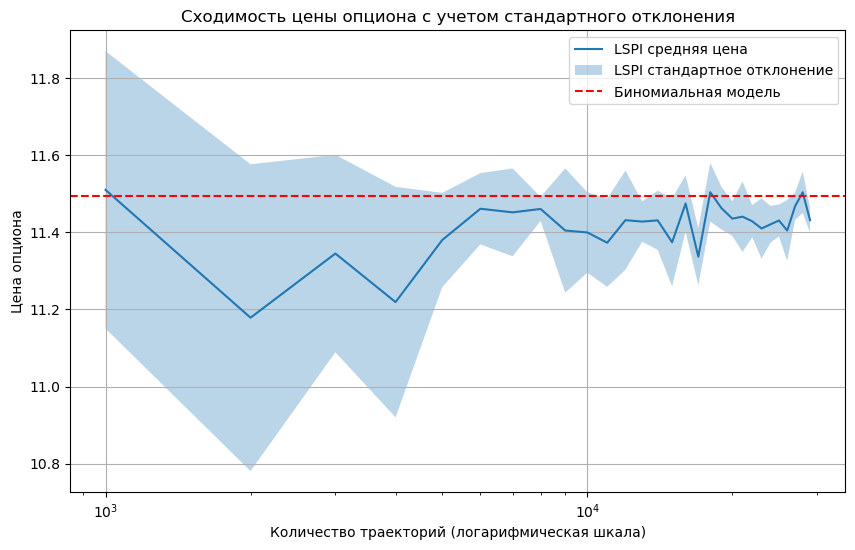

In [16]:
option_params = {
    "asset0": 90.0,
    "sigma": 0.2,
    "r": 0.05,
    "strike": 100.0,
    "t": 1.0,
    "cnt_times": 365
}

cnt_traj_list = [i for i in range(1000, 30_000, 1000)]
num_repeats = 5  

mean_prices, std_prices = evaluate_pricer_with_std(
    sampler_class=GeometricBrownianMotionPutSampler,
    pricer_class=LSPIPricer,
    cnt_traj_list=cnt_traj_list,
    num_repeats=num_repeats,
    **option_params
)

plot_prices_with_std(cnt_traj_list, mean_prices, std_prices, label='LSPI', reference_price=11.49347975)

## AMC на трейне и тесте

/tmp/ipykernel_39733/2890370929.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx, cnt_traj in enumerate(tqdm(cnt_trajectories_list, desc="Computing prices")):


Computing prices:   0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC train price at idx 0, cnt_traj 1000: 11.68722961508614


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC test price at idx 0, cnt_traj 1000: 11.336987858314908


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC train price at idx 1, cnt_traj 2000: 11.600170422302607


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC test price at idx 1, cnt_traj 2000: 10.744588510319275


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC train price at idx 2, cnt_traj 3000: 11.728153198176113


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC test price at idx 2, cnt_traj 3000: 11.39124551040539


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC train price at idx 3, cnt_traj 4000: 11.24181164200473


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC test price at idx 3, cnt_traj 4000: 11.421625224275726


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC train price at idx 4, cnt_traj 5000: 11.476125951622222


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC test price at idx 4, cnt_traj 5000: 11.500506966823805


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC train price at idx 5, cnt_traj 6000: 11.431698024388636


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC test price at idx 5, cnt_traj 6000: 11.490332071806032


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC train price at idx 6, cnt_traj 7000: 11.430480470908144


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC test price at idx 6, cnt_traj 7000: 11.462134971027778


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC train price at idx 7, cnt_traj 8000: 11.450923218304764


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC test price at idx 7, cnt_traj 8000: 11.570841235693981


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC train price at idx 8, cnt_traj 9000: 11.575397507917735


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC test price at idx 8, cnt_traj 9000: 11.363502626900186


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC train price at idx 9, cnt_traj 10000: 11.40692076256744


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC test price at idx 9, cnt_traj 10000: 11.547769046237933


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC train price at idx 10, cnt_traj 11000: 11.450408870429884


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC test price at idx 10, cnt_traj 11000: 11.383893491506452


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC train price at idx 11, cnt_traj 12000: 11.508141695986517


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC test price at idx 11, cnt_traj 12000: 11.432877650170363


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC train price at idx 12, cnt_traj 13000: 11.515730958457423


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC test price at idx 12, cnt_traj 13000: 11.30656459880249


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC train price at idx 13, cnt_traj 14000: 11.514030336392308


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC test price at idx 13, cnt_traj 14000: 11.486577238029506


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC train price at idx 14, cnt_traj 15000: 11.564190319678692


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC test price at idx 14, cnt_traj 15000: 11.427501305479172


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC train price at idx 15, cnt_traj 16000: 11.452690204652255


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC test price at idx 15, cnt_traj 16000: 11.60086536711875


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC train price at idx 16, cnt_traj 17000: 11.521754025701112


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC test price at idx 16, cnt_traj 17000: 11.382949130816733


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC train price at idx 17, cnt_traj 18000: 11.372162277316834


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC test price at idx 17, cnt_traj 18000: 11.409422528889595


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC train price at idx 18, cnt_traj 19000: 11.592828140878712


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC test price at idx 18, cnt_traj 19000: 11.490880883065087


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC train price at idx 19, cnt_traj 20000: 11.505868257912493


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC test price at idx 19, cnt_traj 20000: 11.428076786796044


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC train price at idx 20, cnt_traj 21000: 11.533311328338826


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC test price at idx 20, cnt_traj 21000: 11.236616467831595


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC train price at idx 21, cnt_traj 22000: 11.49722786755997


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC test price at idx 21, cnt_traj 22000: 11.390929587473833


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC train price at idx 22, cnt_traj 23000: 11.57190094456433


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC test price at idx 22, cnt_traj 23000: 11.462628965214789


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC train price at idx 23, cnt_traj 24000: 11.440103292901995


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC test price at idx 23, cnt_traj 24000: 11.501288812647802


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC train price at idx 24, cnt_traj 25000: 11.474664696560888


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC test price at idx 24, cnt_traj 25000: 11.404285242279817


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC train price at idx 25, cnt_traj 26000: 11.558140683435257


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC test price at idx 25, cnt_traj 26000: 11.420431644835945


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC train price at idx 26, cnt_traj 27000: 11.458080663412531


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC test price at idx 26, cnt_traj 27000: 11.450649693294466


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC train price at idx 27, cnt_traj 28000: 11.553166238705785


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC test price at idx 27, cnt_traj 28000: 11.513606939220663


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC train price at idx 28, cnt_traj 29000: 11.49698408834769


  0%|          | 0/364 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?it/s]

AMC test price at idx 28, cnt_traj 29000: 11.535719260139132
Length of cnt_trajectories_list: 29
Length of amc_train_prices: 29
Length of amc_test_prices: 29


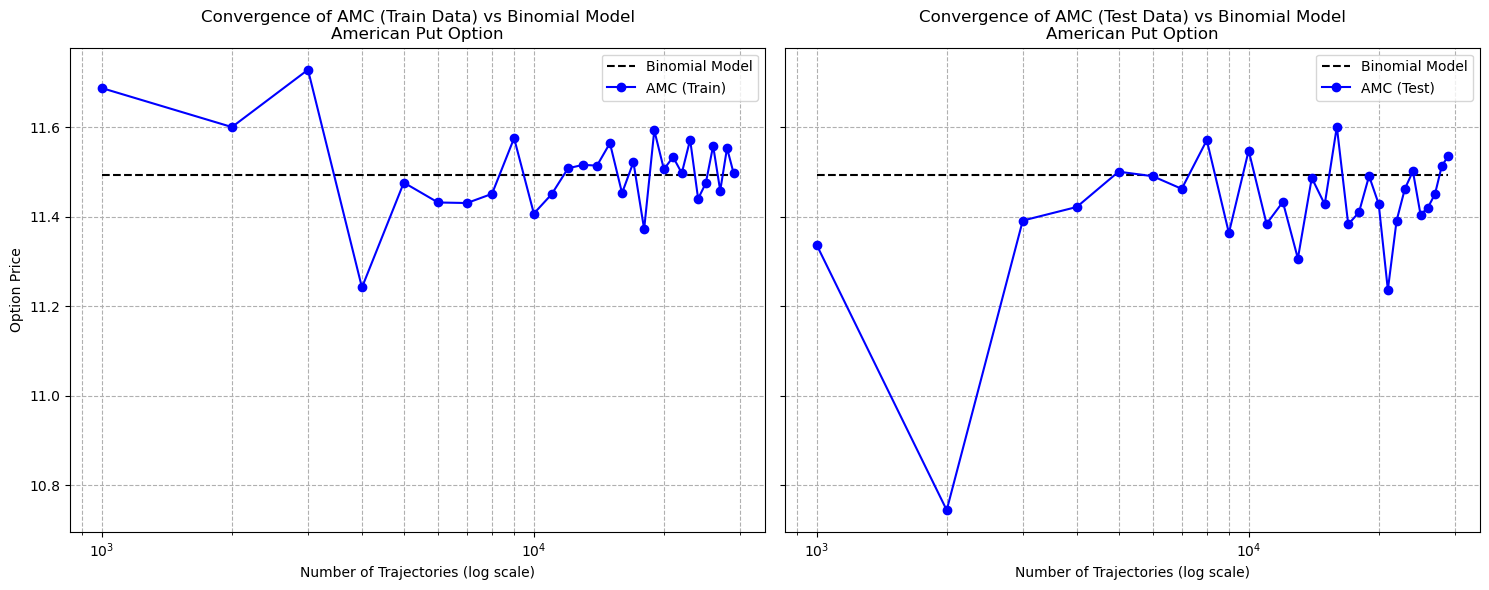

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

# Fixed option parameters (in-the-money American put)
option_params = {
    "asset0": 90.0,  
    "sigma": 0.2,
    "r": 0.05,
    "strike": 100.0,
    "t": 1.0,
    "cnt_times": 365   
}

cnt_trajectories_list = np.arange(1000, 30000, 1000)

binomial_params = option_params.copy()
binomial_params["cnt_times"] = 1000 
_, binomial_price = price_gbm_put(**binomial_params)
binomial_price = binomial_price[0]

# Clear lists to avoid accumulation from previous runs
amc_train_prices = []
amc_test_prices = []

# Compute prices for each number of trajectories
for idx, cnt_traj in enumerate(tqdm(cnt_trajectories_list, desc="Computing prices")):
    # Sampler for both training and testing (trajectories will be regenerated on each sample() call)
    sampler = GeometricBrownianMotionPutSampler(
        cnt_trajectories=cnt_traj,
        seed=None,  # No fixed seed to allow different trajectories on each sample() call
        **option_params
    )

    # AMC pricing
    amc = PricerAmericanMonteCarlo(sampler=sampler, regularization_alpha=1e-3)
    
    # Train on first sampler.sample() call and get train price
    amc_train_price_history = amc.price(test=False, quiet=True)
    amc_train_price = amc_train_price_history[0]  # Price at t=0
    amc_train_prices.append(amc_train_price)
    print(f"AMC train price at idx {idx}, cnt_traj {cnt_traj}: {amc_train_price}")

    # Predict on second sampler.sample() call (new trajectories) and get test price
    amc_test_price_history = amc.price(test=True, quiet=True)
    amc_test_price = amc_test_price_history[0]  # Price at t=0
    amc_test_prices.append(amc_test_price)
    print(f"AMC test price at idx {idx}, cnt_traj {cnt_traj}: {amc_test_price}")

# Debugging: Check lengths
print(f"Length of cnt_trajectories_list: {len(cnt_trajectories_list)}")
print(f"Length of amc_train_prices: {len(amc_train_prices)}")
print(f"Length of amc_test_prices: {len(amc_test_prices)}")

# Plotting only if lengths match
if len(cnt_trajectories_list) == len(amc_train_prices) == len(amc_test_prices):
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

    # Plot for AMC on train data
    ax1.plot(cnt_trajectories_list, [binomial_price] * len(cnt_trajectories_list), 
             label='Binomial Model', linestyle='--', color='black')
    ax1.plot(cnt_trajectories_list, amc_train_prices, 
             label='AMC (Train)', marker='o', color='blue')
    ax1.set_xscale('log')
    ax1.set_xlabel('Number of Trajectories (log scale)')
    ax1.set_ylabel('Option Price')
    ax1.set_title('Convergence of AMC (Train Data) vs Binomial Model\nAmerican Put Option')
    ax1.legend()
    ax1.grid(True, which="both", ls="--")

    # Plot for AMC on test data
    ax2.plot(cnt_trajectories_list, [binomial_price] * len(cnt_trajectories_list), 
             label='Binomial Model', linestyle='--', color='black')
    ax2.plot(cnt_trajectories_list, amc_test_prices, 
             label='AMC (Test)', marker='o', color='blue')
    ax2.set_xscale('log')
    ax2.set_xlabel('Number of Trajectories (log scale)')
    ax2.set_title('Convergence of AMC (Test Data) vs Binomial Model\nAmerican Put Option')
    ax2.legend()
    ax2.grid(True, which="both", ls="--")

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Save the plot
    plt.savefig('convergence_plot_amc_train_test.png')
else:
    print("Error: Lengths of cnt_trajectories_list, amc_train_prices, and amc_test_prices do not match!")